In [1]:
import sqlite3
# import os.path
import hashlib
import pandas as pd
import numpy as np

db = './../data/Arne/disaggregation.db'

conn = sqlite3.connect(db)

df = pd.read_sql_query("SELECT date,demand_power_L1+demand_power_L2+demand_power_L3 as 'demand' FROM loads WHERE date BETWEEN datetime('now', '-6 days') AND datetime('now', 'localtime');", conn)
conn.close()# close db

df['datetime'] = pd.to_datetime(df['date'])
df.sort_values(by='datetime',ascending=True);


In [2]:
df['dp'] = df['demand'] - df['demand'].shift(1)
df['dp-'] = [0-x if x <=0 else 0 for x in df['dp']]
df['dp+'] = [x if x >=0 else 0 for x in df['dp']]



In [3]:
print(df)

                      date  demand            datetime   dp  dp-  dp+
0      2018-03-22 12:09:38    55.0 2018-03-22 12:09:38  NaN  0.0  0.0
1      2018-03-22 12:09:48    56.0 2018-03-22 12:09:48  1.0  0.0  1.0
2      2018-03-22 12:09:58    61.0 2018-03-22 12:09:58  5.0  0.0  5.0
3      2018-03-22 12:10:08    56.0 2018-03-22 12:10:08 -5.0  5.0  0.0
4      2018-03-22 12:10:18    55.0 2018-03-22 12:10:18 -1.0  1.0  0.0
5      2018-03-22 12:10:28    56.0 2018-03-22 12:10:28  1.0  0.0  1.0
6      2018-03-22 12:10:38    55.0 2018-03-22 12:10:38 -1.0  1.0  0.0
7      2018-03-22 12:10:48    55.0 2018-03-22 12:10:48  0.0  0.0  0.0
8      2018-03-22 12:10:58    56.0 2018-03-22 12:10:58  1.0  0.0  1.0
9      2018-03-22 12:11:08    56.0 2018-03-22 12:11:08  0.0  0.0  0.0
10     2018-03-22 12:11:17    55.0 2018-03-22 12:11:17 -1.0  1.0  0.0
11     2018-03-22 12:11:27    55.0 2018-03-22 12:11:27  0.0  0.0  0.0
12     2018-03-22 12:11:37    56.0 2018-03-22 12:11:37  1.0  0.0  1.0
13     2018-03-22 12

In [4]:
# add user defined loads (that are always on)
user_loads = {'modem':10,'rPi':4}
baseload = 0
for user_load in user_loads:
    df.loc[:,user_load]  = user_loads[user_load]
    baseload = baseload + user_loads[user_load]
#     df.loc[:,] = np.array([df['demand'].min()] * len(df))


In [5]:
# find baseload and determine remaining unkwown profile
df.loc[:,'baseload'] = np.array([df['demand'].min()-baseload] * len(df)) #sets baseload colum to min value minus users defined loads
df.loc[:,'unknown'] = df.loc[:,'demand'] - df.loc[:,'baseload']-baseload #calculate remaining load = demand - baseload(s)


# find square loads and save them to a dict

In [6]:
# create a dict to safe found devices/loads
loads = dict()

for x in range(1,len(df)):
    #filter for dP+ with minimim power
    if df.loc[x,'dp+'] > 10:
        print(' ') #new line in output
        print ('start dp>100:',df.loc[x,'datetime'],'start P:',df.loc[x-1,'unknown'],', dP+:' ,df.loc[x,'dp+'])
        
        #look forwar in time to see how long load remains on
        for y in range(x+1,len(df)):
            #find dP- of same/simulair size 
            if df.loc[y,'dp-'] > 0.9 *df.loc[x,'dp+'] and df.loc[y,'dp-'] < 1.1 *df.loc[x,'dp+']:
                print ('stop dP-:',df.loc[y,'datetime'],'dP-:' ,df.loc[y,'dp-'])
                break
            # check if load does not drop below start power (this means is must have been turned of or other loads were already present (=ON))    
            if df.loc[y,'unknown'] <= df.loc[x-1,'unknown']:
                print ('stop demand:',df.loc[x,'datetime'] ,df.loc[y,'unknown'], ' <= ',df.loc[x-1,'unknown'])
                break
            # check for 50% load reduction
            if df.loc[y,'unknown']<df.loc[x-1,'unknown']+0.5*df.loc[x,'dp+']:
                print ('stop 50% load reduction:',df.loc[x,'datetime'] ,df.loc[y,'unknown'], ' < ',df.loc[x-1,'unknown'],'+',0.5*df.loc[x,'dp+'])
                break
            
        
        print(x,y,(df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).mean())
        
        # calculate key parameters
        mean = (df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).mean()
        max = (df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).max()
        min = (df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).min()
        std = (df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).std()
        time = pd.Timedelta(pd.to_datetime(df['datetime'][y])-pd.to_datetime(df['datetime'][x]))
        noise = df.loc[x+1:y-1,'dp'].abs().mean()
        
        print('mean load:',mean)
        print('max load:',max)
        print('std load:',std)
        print('noise:',noise)
        print('time past:',time)


        print('found profile from ',df.loc[x-1,'datetime'],'to',df.loc[y,'datetime'])
        profile = list(df.loc[x-1:y,'unknown']-df.loc[x-1,'unknown'])
        print(profile)
        
        
#         plt.plot(range(x,y),profile)
#         plt.title('A simple chirp')
#         plt.show()
#         break
        try:
            #drop loads which do not have a square looking profile.
            if (std/mean > 0.15):
                print('dropped because of large std:',std/mean)
                continue

            #drop loads which do not have odd start compared to mean
            if( abs(mean-df.loc[x,'dp+'])/df.loc[x,'dp+'] > 0.2):    
                print('dropped because large difference between mean and start dp+:',abs(mean-df.loc[x,'dp+'])/df.loc[x,'dp+'])
                continue
        except:
            print('Something went wrong in analysing found load, dropping ....')
            continue
#         print('hist:',df.hist(bins=10))
        
        # save this load to the distionairy (group by 'fingerprint')
        fingerprint = str(int(round(mean,-2)))+'_'#+str(int(left_round(df.loc[x,'dp+'],2)))
        temp = {'index':{'start':x,'stop':y},'time':time,'mean':mean,'max':max,'profile':profile}
        try:
            loads[fingerprint][len(loads[fingerprint])] = temp
        except:
            loads[fingerprint] = {0:temp}
            df[fingerprint] = 0 #add new colum to the dataframe before inserting found loads (only on first occurance!)
        
        df.loc[x:y-1,fingerprint] = profile[1:-1]
        df.loc[x:y-1,'unknown'] = df.loc[x:y-1,'unknown'] - profile[1:-1]
        print('Saved with fingerprint:',fingerprint)



 
start dp>100: 2018-03-22 13:28:24 start P: 30.0 , dP+: 2008.0
stop dP-: 2018-03-22 13:29:44 dP-: 1996.0
477 485 1996.875
mean load: 1996.875
max load: 2008.0
std load: 5.19443383412888
noise: 4.285714285714286
time past: 0 days 00:01:20
found profile from  2018-03-22 13:28:14 to 2018-03-22 13:29:44
[0.0, 2008.0, 1993.0, 1990.0, 1998.0, 1997.0, 1996.0, 1997.0, 1996.0, 0.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-22 15:31:46 start P: 38.0 , dP+: 2036.0
stop dP-: 2018-03-22 15:33:05 dP-: 2018.0
1224 1232 2018.75
mean load: 2018.75
max load: 2036.0
std load: 9.269766525030251
noise: 6.714285714285714
time past: 0 days 00:01:19
found profile from  2018-03-22 15:31:36 to 2018-03-22 15:33:05
[0.0, 2036.0, 2024.0, 2016.0, 2026.0, 2017.0, 2010.0, 2010.0, 2011.0, -7.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-22 16:49:43 start P: 29.0 , dP+: 11.0
stop 50% load reduction: 2018-03-22 16:49:43 31.0  <  29.0 + 5.5
1696 1697 11.0
mean load: 11.0
max load: 11.0
std load: n

max load: 137.0
std load: 24.12985702402731
noise: 17.666666666666668
time past: 0 days 00:00:39
found profile from  2018-03-23 09:48:05 to 2018-03-23 09:48:54
[0.0, 137.0, 92.0, 92.0, 84.0, 66.0]
dropped because of large std: 0.23831957554594874
 
start dp>100: 2018-03-23 10:23:15 start P: 32.0 , dP+: 16.0
stop demand: 2018-03-23 10:23:15 1.0  <=  32.0
8076 8159 238.13253012048193
mean load: 238.13253012048193
max load: 2028.0
std load: 582.9685547952872
noise: 41.13414634146341
time past: 0 days 00:13:43
found profile from  2018-03-23 10:23:05 to 2018-03-23 10:36:58
[0.0, 16.0, 29.0, 21.0, 17.0, 22.0, 28.0, 30.0, 32.0, 34.0, 35.0, 36.0, 36.0, 37.0, 38.0, 38.0, 39.0, 40.0, 40.0, 40.0, 40.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 42.0, 42.0, 49.0, 49.0, 49.0, 49.0, 50.0, 43.0, 42.0, 43.0, 43.0, 43.0, 43.0, 43.0, 50.0, 50.0, 43.0, 44.0, 44.0, 44.0, 44.0, 44.0, 45.0, 45.0, 45.0, 45.0, 44.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0, 45.0,

[0.0, 14.0, 9.0, 7.0, 15.0, 32.0, 35.0, 37.0, 38.0, 39.0, 41.0, 41.0, 42.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 47.0, 49.0, 49.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 52.0, 52.0, 52.0, 52.0, 52.0, 53.0, 46.0, 46.0, 46.0, 46.0, 54.0, 53.0, 46.0, 47.0, 47.0, 54.0, 54.0, 54.0, 54.0, 55.0, 54.0, 55.0, 55.0, 55.0, 56.0, 55.0, 55.0, 55.0, 55.0, 55.0, 48.0, 56.0, 55.0, 55.0, 56.0, 55.0, 55.0, 55.0, 55.0, 48.0, 48.0, 47.0, 48.0, 47.0, 47.0, 47.0, 53.0, 53.0, 52.0, 52.0, 51.0, 50.0, -24.0]
dropped because of large std: 0.20222010145995392
 
start dp>100: 2018-03-23 22:02:26 start P: 49.0 , dP+: 17.0
stop demand: 2018-03-23 22:02:26 10.0  <=  49.0
12310 12392 34.609756097560975
mean load: 34.609756097560975
max load: 41.0
std load: 5.321180824955674
noise: 1.1851851851851851
time past: 0 days 00:13:32
found profile from  2018-03-23 22:02:16 to 2018-03-23 22:15:58
[0.0, 17.0, 20.0, 22.0, 23.0, 24.0, 26.0, 26.0, 27.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.

found profile from  2018-03-24 07:04:15 to 2018-03-24 07:17:08
[0.0, 18.0, 17.0, 24.0, 33.0, 35.0, 37.0, 38.0, 40.0, 40.0, 41.0, 42.0, 42.0, 42.0, 45.0, 45.0, 45.0, 46.0, 46.0, 46.0, 47.0, 46.0, 47.0, 47.0, 47.0, 47.0, 48.0, 47.0, 48.0, 49.0, 48.0, 48.0, 48.0, 49.0, 49.0, 49.0, 48.0, 49.0, 49.0, 49.0, 50.0, 50.0, 51.0, 51.0, 50.0, 50.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 50.0, 51.0, 51.0, 50.0, 50.0, 50.0, 50.0, 50.0, 51.0, 50.0, 49.0, 49.0, 49.0, 48.0, 48.0, 48.0, 47.0, 47.0, 47.0, 46.0, 45.0, 43.0, -30.0]
dropped because large difference between mean and start dp+: 1.56998556999
 
start dp>100: 2018-03-24 07:35:47 start P: 1.0 , dP+: 2038.0
stop dP-: 2018-03-24 07:36:56 dP-: 2030.0
15782 15789 2029.2857142857142
mean load: 2029.2857142857142
max load: 2038.0
std load: 5.964178784328029
noise: 6.0
time past: 0 days 00:01:09
found profile from  2018-03-24 07:35:37 to 2018-03-24 07:36:56
[0.0, 2038.0, 2029.0, 2020.0, 2024.0, 2030.0, 2034.0, 2030.0, 0.0]
Saved wi

noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-24 11:25:19 to 2018-03-24 11:25:39
[0.0, 740.0, 0.0]
Saved with fingerprint: 700_
 
start dp>100: 2018-03-24 11:29:07 start P: 1.0 , dP+: 730.0
stop demand: 2018-03-24 11:29:07 1.0  <=  1.0
17195 17204 1877.4444444444443
mean load: 1877.4444444444443
max load: 2040.0
std load: 430.36470322016163
noise: 168.125
time past: 0 days 00:01:29
found profile from  2018-03-24 11:28:57 to 2018-03-24 11:30:36
[0.0, 730.0, 2040.0, 2025.0, 2017.0, 2015.0, 2014.0, 2018.0, 2017.0, 2021.0, 0.0]
dropped because of large std: 0.22922899502760577
 
start dp>100: 2018-03-24 11:29:17 start P: 731.0 , dP+: 1310.0
stop demand: 2018-03-24 11:29:17 1.0  <=  731.0
17196 17204 1290.875
mean load: 1290.875
max load: 1310.0
std load: 8.47580590352833
noise: 5.0
time past: 0 days 00:01:19
found profile from  2018-03-24 11:29:07 to 2018-03-24 11:30:36
[0.0, 1310.0, 1295.0, 1287.0, 1285.0, 1284.0, 1288.0, 1287.0, 1291.0, -730.0]
Saved with fingerprint:

17848 17849 735.0
mean load: 735.0
max load: 735.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-24 13:16:47 to 2018-03-24 13:17:07
[0.0, 735.0, 1.0]
Saved with fingerprint: 700_
 
start dp>100: 2018-03-24 13:20:55 start P: 1.0 , dP+: 736.0
stop dP-: 2018-03-24 13:21:05 dP-: 735.0
17872 17873 736.0
mean load: 736.0
max load: 736.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-24 13:20:45 to 2018-03-24 13:21:05
[0.0, 736.0, 1.0]
Saved with fingerprint: 700_
 
start dp>100: 2018-03-24 13:24:53 start P: 1.0 , dP+: 740.0
stop dP-: 2018-03-24 13:25:03 dP-: 739.0
17896 17897 740.0
mean load: 740.0
max load: 740.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-24 13:24:43 to 2018-03-24 13:25:03
[0.0, 740.0, 1.0]
Saved with fingerprint: 700_
 
start dp>100: 2018-03-24 13:28:51 start P: 1.0 , dP+: 743.0
stop dP-: 2018-03-24 13:29:01 dP-: 742.0
17920 17921 743.0
mean load: 743.0
max load: 743.0
s

18986 18989 51.666666666666664
mean load: 51.666666666666664
max load: 71.0
std load: 17.47378989610821
noise: 17.0
time past: 0 days 00:00:30
found profile from  2018-03-24 16:24:43 to 2018-03-24 16:25:23
[0.0, 71.0, 47.0, 37.0, 34.0]
dropped because of large std: 0.3382023850859654
 
start dp>100: 2018-03-24 17:40:51 start P: 30.0 , dP+: 2015.0
stop dP-: 2018-03-24 17:42:00 dP-: 1997.0
19446 19453 2002.2857142857142
mean load: 2002.2857142857142
max load: 2015.0
std load: 6.237368187365717
noise: 3.5
time past: 0 days 00:01:09
found profile from  2018-03-24 17:40:41 to 2018-03-24 17:42:00
[0.0, 2015.0, 2006.0, 2000.0, 1999.0, 1998.0, 2000.0, 1998.0, 1.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-24 19:40:44 start P: 41.0 , dP+: 2078.0
stop dP-: 2018-03-24 19:41:53 dP-: 2050.0
20172 20179 2051.5714285714284
mean load: 2051.5714285714284
max load: 2078.0
std load: 12.326896647266128
noise: 8.5
time past: 0 days 00:01:09
found profile from  2018-03-24 19:40:34 to 2018-03-24 

mean load: 2077.5714285714284
max load: 2099.0
std load: 9.846440014156432
noise: 6.666666666666667
time past: 0 days 00:01:09
found profile from  2018-03-25 13:59:13 to 2018-03-25 14:00:32
[0.0, 2099.0, 2073.0, 2069.0, 2073.0, 2077.0, 2077.0, 2075.0, -3.0]
Saved with fingerprint: 2100_
 
start dp>100: 2018-03-25 15:04:07 start P: 39.0 , dP+: 12.0
stop 50% load reduction: 2018-03-25 15:04:07 43.0  <  39.0 + 6.0
27217 27218 12.0
mean load: 12.0
max load: 12.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-25 15:03:57 to 2018-03-25 15:04:17
[0.0, 12.0, 4.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-25 15:29:03 start P: 31.0 , dP+: 25.0
stop demand: 2018-03-25 15:29:03 2.0  <=  31.0
27368 27449 44.77777777777778
mean load: 44.77777777777778
max load: 51.0
std load: 6.63701740241805
noise: 0.9625
time past: 0 days 00:13:23
found profile from  2018-03-25 15:28:53 to 2018-03-25 15:42:26
[0.0, 25.0, 14.0, 19.0, 28.0, 32.0, 35.0, 37.0, 39.0, 39.0, 40.0

time past: 0 days 00:00:10
found profile from  2018-03-25 18:57:37 to 2018-03-25 18:57:57
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-25 18:57:57 start P: 193.0 , dP+: 11.0
stop demand: 2018-03-25 18:57:57 193.0  <=  193.0
28633 28634 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-25 18:57:47 to 2018-03-25 18:58:07
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-25 19:01:25 start P: 205.0 , dP+: 13.0
stop dP-: 2018-03-25 19:07:21 dP-: 12.0
28654 28690 436.05555555555554
mean load: 436.05555555555554
max load: 2072.0
std load: 813.1421223323209
noise: 60.02857142857143
time past: 0 days 00:05:56
found profile from  2018-03-25 19:01:15 to 2018-03-25 19:07:21
[0.0, 13.0, 18.0, 17.0, 27.0, 34.0, 37.0, 39.0, 42.0, 42.0, 42.0, 44.0, 44.0, 45.0, 46.0, 42.0, 42.0, 43.0, 50.0, 49.0, 51.0, 50.0, 50.0, 50.0, 50.0, 51.0, 51.0,

start dp>100: 2018-03-25 23:32:33 start P: 7.0 , dP+: 765.0
stop dP-: 2018-03-25 23:32:53 dP-: 745.0
30296 30298 754.5
mean load: 754.5
max load: 765.0
std load: 14.849242404917497
noise: 21.0
time past: 0 days 00:00:20
found profile from  2018-03-25 23:32:23 to 2018-03-25 23:32:53
[0.0, 765.0, 744.0, -1.0]
Saved with fingerprint: 800_
 
start dp>100: 2018-03-25 23:36:11 start P: 7.0 , dP+: 755.0
stop dP-: 2018-03-25 23:36:21 dP-: 755.0
30318 30319 755.0
mean load: 755.0
max load: 755.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-25 23:36:01 to 2018-03-25 23:36:21
[0.0, 755.0, 0.0]
Saved with fingerprint: 800_
 
start dp>100: 2018-03-25 23:39:49 start P: 7.0 , dP+: 751.0
stop dP-: 2018-03-25 23:39:59 dP-: 753.0
30340 30341 751.0
mean load: 751.0
max load: 751.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-25 23:39:39 to 2018-03-25 23:39:59
[0.0, 751.0, -2.0]
Saved with fingerprint: 800_
 
start dp>100: 2018-03-25 23

start dp>100: 2018-03-26 02:06:08 start P: 4.0 , dP+: 2088.0
stop dP-: 2018-03-26 02:07:27 dP-: 2042.0
31226 31234 2047.5
mean load: 2047.5
max load: 2088.0
std load: 16.596040835951552
noise: 8.0
time past: 0 days 00:01:19
found profile from  2018-03-26 02:05:58 to 2018-03-26 02:07:27
[0.0, 2088.0, 2048.0, 2041.0, 2040.0, 2040.0, 2042.0, 2039.0, 2042.0, 0.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-26 02:21:19 start P: 4.0 , dP+: 779.0
stop dP-: 2018-03-26 02:21:29 dP-: 776.0
31318 31319 779.0
mean load: 779.0
max load: 779.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 02:21:09 to 2018-03-26 02:21:29
[0.0, 779.0, 3.0]
Saved with fingerprint: 800_
 
start dp>100: 2018-03-26 02:23:18 start P: 4.0 , dP+: 775.0
stop dP-: 2018-03-26 02:23:38 dP-: 754.0
31330 31332 764.5
mean load: 764.5
max load: 775.0
std load: 14.849242404917497
noise: 21.0
time past: 0 days 00:00:20
found profile from  2018-03-26 02:23:08 to 2018-03-26 02:23:38
[0.0, 7

found profile from  2018-03-26 05:49:43 to 2018-03-26 05:55:20
[0.0, 15.0, 16.0, 19.0, 18.0, 19.0, 19.0, 19.0, 19.0, 20.0, 21.0, 21.0, 21.0, 21.0, 22.0, 24.0, 24.0, 25.0, 29.0, 27.0, 25.0, 25.0, 25.0, 25.0, 25.0, 33.0, 27.0, 27.0, 26.0, 26.0, 26.0, 25.0, 24.0, 11.0, -1.0]
dropped because of large std: 0.1950205641470888
 
start dp>100: 2018-03-26 05:59:48 start P: 34.0 , dP+: 106.0
stop demand: 2018-03-26 05:59:48 33.0  <=  34.0
32641 32680 87.33333333333333
mean load: 87.33333333333333
max load: 106.0
std load: 8.959949874546506
noise: 2.6052631578947367
time past: 0 days 00:06:26
found profile from  2018-03-26 05:59:38 to 2018-03-26 06:06:14
[0.0, 106.0, 81.0, 88.0, 88.0, 87.0, 90.0, 88.0, 88.0, 88.0, 90.0, 90.0, 90.0, 94.0, 95.0, 95.0, 91.0, 90.0, 91.0, 91.0, 93.0, 91.0, 92.0, 92.0, 92.0, 92.0, 90.0, 91.0, 90.0, 91.0, 91.0, 90.0, 91.0, 87.0, 78.0, 65.0, 70.0, 68.0, 66.0, 65.0, -1.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-26 06:09:52 start P: 36.0 , dP+: 89.0
stop deman

stop demand: 2018-03-26 08:18:21 20.0  <=  21.0
33480 33531 85.45098039215686
mean load: 85.45098039215686
max load: 101.0
std load: 6.090365261592104
noise: 0.72
time past: 0 days 00:08:25
found profile from  2018-03-26 08:18:11 to 2018-03-26 08:26:46
[0.0, 98.0, 99.0, 101.0, 100.0, 99.0, 98.0, 95.0, 92.0, 91.0, 89.0, 88.0, 87.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 86.0, 85.0, 85.0, 84.0, 84.0, 84.0, 84.0, 84.0, 83.0, 83.0, 83.0, 84.0, 84.0, 84.0, 84.0, 82.0, 84.0, 83.0, 81.0, 81.0, 81.0, 81.0, 80.0, 80.0, 79.0, 79.0, 79.0, 80.0, 79.0, 79.0, 79.0, 78.0, -1.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-26 08:50:13 start P: 13.0 , dP+: 96.0
stop demand: 2018-03-26 08:50:13 13.0  <=  13.0
33673 33720 85.46808510638297
mean load: 85.46808510638297
max load: 100.0
std load: 5.7929907565646035
noise: 0.8478260869565217
time past: 0 days 00:07:46
found profile from  2018-03-26 08:50:03 to 2018-03-26 08:57:59
[0.0, 96.0, 100.0, 100.0, 99.0, 98.0, 97.0, 92.0, 92.0, 90.0, 87.0, 

std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 13:27:08 to 2018-03-26 13:27:28
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 13:28:08 start P: 92.0 , dP+: 185.0
stop demand: 2018-03-26 13:28:08 21.0  <=  92.0
35356 35357 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:09
found profile from  2018-03-26 13:27:58 to 2018-03-26 13:28:17
[0.0, 0.0, -71.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 13:28:27 start P: 21.0 , dP+: 1879.0
stop dP-: 2018-03-26 13:36:33 dP-: 2065.0
35358 35407 2931.0204081632655
mean load: 2931.0204081632655
max load: 3939.0
std load: 1028.936293172791
noise: 113.625
time past: 0 days 00:08:06
found profile from  2018-03-26 13:28:17 to 2018-03-26 13:36:33
[0.0, 1879.0, 1853.0, 1852.0, 1690.0, 1692.0, 1861.0, 1879.0, 1848.0, 1688.0, 1692.0, 1891.0, 1870.0, 1899.0, 1689.0, 1687.0, 1844.0, 1884.0, 1

Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 13:35:43 start P: 1910.0 , dP+: 12.0
stop demand: 2018-03-26 13:35:43 1910.0  <=  1910.0
35402 35403 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 13:35:33 to 2018-03-26 13:35:53
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 13:36:23 start P: 1910.0 , dP+: 196.0
stop demand: 2018-03-26 13:36:23 1895.0  <=  1910.0
35406 35407 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 13:36:13 to 2018-03-26 13:36:33
[0.0, 0.0, -15.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 13:37:12 start P: 1717.0 , dP+: 183.0
stop dP-: 2018-03-26 13:37:42 dP-: 191.0
35411 35414 183.33333333333334
mean load: 183.33333333333334
max load: 192.0
std load: 8.504900548115382
noise: 12.5
time past:

 
start dp>100: 2018-03-26 13:46:57 start P: 1698.0 , dP+: 169.0
stop 50% load reduction: 2018-03-26 13:46:57 1707.0  <  1698.0 + 84.5
35470 35473 156.0
mean load: 156.0
max load: 170.0
std load: 23.388031127053
noise: 21.0
time past: 0 days 00:00:30
found profile from  2018-03-26 13:46:47 to 2018-03-26 13:47:27
[0.0, 169.0, 170.0, 129.0, 9.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-26 13:47:56 start P: 188.0 , dP+: 71.0
stop 50% load reduction: 2018-03-26 13:47:56 197.0  <  188.0 + 35.5
35476 35477 71.0
mean load: 71.0
max load: 71.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 13:47:47 to 2018-03-26 13:48:06
[0.0, 71.0, 9.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-26 13:48:36 start P: 134.0 , dP+: 53.0
stop demand: 2018-03-26 13:48:36 13.0  <=  134.0
35480 35482 42.5
mean load: 42.5
max load: 53.0
std load: 14.849242404917497
noise: 21.0
time past: 0 days 00:00:20
found profile from  2018-03-26 13:48:26 to 2018-03-26 13:

Saved with fingerprint: 2300_
 
start dp>100: 2018-03-26 14:01:09 start P: 113.0 , dP+: 192.0
stop demand: 2018-03-26 14:01:09 113.0  <=  113.0
35556 35557 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 14:00:59 to 2018-03-26 14:01:19
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 14:01:29 start P: 113.0 , dP+: 97.0
stop demand: 2018-03-26 14:01:29 113.0  <=  113.0
35558 35559 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 14:01:19 to 2018-03-26 14:01:39
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 14:01:39 start P: 113.0 , dP+: 17.0
stop demand: 2018-03-26 14:01:39 113.0  <=  113.0
35559 35560 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 14:01:29 to 2018-03-26 14:01:4

stop dP-: 2018-03-26 14:16:50 dP-: 177.0
35649 35651 187.0
mean load: 187.0
max load: 196.0
std load: 12.727922061357855
noise: 18.0
time past: 0 days 00:00:19
found profile from  2018-03-26 14:16:21 to 2018-03-26 14:16:50
[0.0, 196.0, 178.0, 1.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-26 14:17:00 start P: 124.0 , dP+: 185.0
stop demand: 2018-03-26 14:17:00 123.0  <=  124.0
35652 35654 173.5
mean load: 173.5
max load: 185.0
std load: 16.263455967290593
noise: 23.0
time past: 0 days 00:00:20
found profile from  2018-03-26 14:16:50 to 2018-03-26 14:17:20
[0.0, 185.0, 162.0, -1.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-26 14:17:30 start P: 123.0 , dP+: 203.0
stop dP-: 2018-03-26 14:17:50 dP-: 195.0
35655 35657 199.0
mean load: 199.0
max load: 203.0
std load: 5.656854249492381
noise: 8.0
time past: 0 days 00:00:20
found profile from  2018-03-26 14:17:20 to 2018-03-26 14:17:50
[0.0, 203.0, 195.0, 0.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-26 14:18:

time past: 0 days 00:00:10
found profile from  2018-03-26 14:35:00 to 2018-03-26 14:35:20
[0.0, 27.0, -28.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-26 14:35:40 start P: 222.0 , dP+: 26.0
stop demand: 2018-03-26 14:35:40 206.0  <=  222.0
35765 35772 171.28571428571428
mean load: 171.28571428571428
max load: 538.0
std load: 166.04890272217426
noise: 156.83333333333334
time past: 0 days 00:01:09
found profile from  2018-03-26 14:35:30 to 2018-03-26 14:36:49
[0.0, 26.0, 538.0, 123.0, 131.0, 129.0, 127.0, 125.0, -16.0]
dropped because of large std: 0.9694264545915094
 
start dp>100: 2018-03-26 14:35:50 start P: 248.0 , dP+: 512.0
stop 50% load reduction: 2018-03-26 14:35:50 345.0  <  248.0 + 256.0
35766 35767 512.0
mean load: 512.0
max load: 512.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 14:35:40 to 2018-03-26 14:36:00
[0.0, 512.0, 97.0]
Saved with fingerprint: 500_
 
start dp>100: 2018-03-26 14:37:59 start P: 118.0 , dP+: 57.0
stop dema

start dp>100: 2018-03-26 14:52:01 start P: 66.0 , dP+: 24.0
stop dP-: 2018-03-26 16:51:43 dP-: 22.0
35864 36589 309.8124137931035
mean load: 309.8124137931035
max load: 3987.0
std load: 709.8737052955232
noise: 44.66574585635359
time past: 0 days 01:59:42
found profile from  2018-03-26 14:51:51 to 2018-03-26 16:51:43
[0.0, 0.0, 44.0, 1968.0, 2144.0, 2075.0, 2106.0, 1927.0, 1935.0, 2154.0, 2109.0, 2209.0, 2020.0, 2018.0, 2026.0, 2287.0, 2196.0, 225.0, 118.0, 117.0, 423.0, 469.0, 441.0, 153.0, 120.0, 120.0, 448.0, 443.0, 352.0, 97.0, 98.0, 97.0, 404.0, 461.0, 250.0, 29.0, 30.0, 31.0, 372.0, 33.0, 54.0, 54.0, 55.0, 54.0, 53.0, 172.0, 395.0, 116.0, 87.0, 81.0, 688.0, 49.0, 30.0, 118.0, 29.0, 29.0, 29.0, 44.0, 73.0, 130.0, 30.0, 29.0, 29.0, 109.0, 219.0, 234.0, 174.0, 173.0, 243.0, 276.0, 308.0, 418.0, 340.0, 367.0, 373.0, 366.0, 131.0, 132.0, 132.0, 170.0, 311.0, 263.0, 472.0, 502.0, 471.0, 457.0, 296.0, 392.0, 388.0, 352.0, 458.0, 461.0, 467.0, 480.0, 486.0, 138.0, 135.0, 134.0, 133.0, 11

std load: 89.50698296781096
noise: 53.875
time past: 0 days 00:01:29
found profile from  2018-03-26 15:02:05 to 2018-03-26 15:03:44
[0.0, 80.0, 190.0, 205.0, 145.0, 144.0, 214.0, 247.0, 279.0, 389.0, 311.0]
dropped because of large std: 0.4255482549975164
 
start dp>100: 2018-03-26 15:02:25 start P: 175.0 , dP+: 110.0
stop 50% load reduction: 2018-03-26 15:02:25 197.0  <  175.0 + 55.0
35927 35939 181.91666666666666
mean load: 181.91666666666666
max load: 309.0
std load: 82.85744420754276
noise: 39.90909090909091
time past: 0 days 00:01:59
found profile from  2018-03-26 15:02:15 to 2018-03-26 15:04:24
[0.0, 110.0, 125.0, 65.0, 64.0, 134.0, 167.0, 199.0, 309.0, 231.0, 258.0, 264.0, 257.0, 22.0]
dropped because of large std: 0.4554692306415543
 
start dp>100: 2018-03-26 15:02:35 start P: 285.0 , dP+: 15.0
stop demand: 2018-03-26 15:02:35 240.0  <=  285.0
35928 35929 15.0
mean load: 15.0
max load: 15.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 15:02

std load: 4.924428900898052
noise: 8.333333333333334
time past: 0 days 00:00:40
found profile from  2018-03-26 15:12:09 to 2018-03-26 15:12:59
[0.0, 14.0, 22.0, 14.0, 23.0, -9.0]
dropped because of large std: 0.26983172059715355
 
start dp>100: 2018-03-26 15:13:09 start P: 162.0 , dP+: 11.0
stop demand: 2018-03-26 15:13:09 118.0  <=  162.0
35992 35996 23.25
mean load: 23.25
max load: 31.0
std load: 9.322910847297997
noise: 6.666666666666667
time past: 0 days 00:00:39
found profile from  2018-03-26 15:12:59 to 2018-03-26 15:13:48
[0.0, 11.0, 21.0, 30.0, 31.0, -44.0]
dropped because of large std: 0.40098541278701066
 
start dp>100: 2018-03-26 15:13:58 start P: 118.0 , dP+: 90.0
stop demand: 2018-03-26 15:13:58 111.0  <=  118.0
35997 36024 963.0370370370371
mean load: 963.0370370370371
max load: 2113.0
std load: 1003.4332020035968
noise: 83.61538461538461
time past: 0 days 00:04:28
found profile from  2018-03-26 15:13:48 to 2018-03-26 15:18:26
[0.0, 90.0, 79.0, 81.0, 81.0, 83.0, 82.0, 81.

start dp>100: 2018-03-26 16:39:30 start P: 90.0 , dP+: 94.0
stop dP-: 2018-03-26 16:54:02 dP-: 87.0
36515 36603 112.20454545454545
mean load: 112.20454545454545
max load: 215.0
std load: 34.57364589677535
noise: 12.218390804597702
time past: 0 days 00:14:32
found profile from  2018-03-26 16:39:20 to 2018-03-26 16:54:02
[0.0, 94.0, 97.0, 98.0, 97.0, 97.0, 95.0, 92.0, 91.0, 103.0, 103.0, 103.0, 102.0, 102.0, 101.0, 102.0, 101.0, 101.0, 100.0, 100.0, 99.0, 98.0, 104.0, 100.0, 100.0, 109.0, 108.0, 101.0, 97.0, 96.0, 96.0, 106.0, 193.0, 188.0, 191.0, 192.0, 192.0, 191.0, 192.0, 190.0, 192.0, 200.0, 121.0, 119.0, 104.0, 107.0, 107.0, 107.0, 106.0, 158.0, 89.0, 94.0, 94.0, 94.0, 93.0, 94.0, 93.0, 93.0, 94.0, 93.0, 93.0, 92.0, 93.0, 93.0, 93.0, 93.0, 93.0, 93.0, 92.0, 93.0, 98.0, 104.0, 103.0, 103.0, 118.0, 96.0, 96.0, 96.0, 102.0, 102.0, 149.0, 102.0, 99.0, 215.0, 98.0, 160.0, 48.0, 48.0, 135.0, 48.0]
dropped because of large std: 0.3081305285513704
 
start dp>100: 2018-03-26 16:40:49 start P

stop demand: 2018-03-26 17:19:50 414.0  <=  414.0
36707 36708 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 17:19:40 to 2018-03-26 17:20:00
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 17:20:19 start P: 414.0 , dP+: 38.0
stop demand: 2018-03-26 17:20:19 408.0  <=  414.0
36710 36711 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 17:20:09 to 2018-03-26 17:20:29
[0.0, 0.0, -6.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 17:20:49 start P: 246.0 , dP+: 181.0
stop dP-: 2018-03-26 17:27:06 dP-: 190.0
36713 36751 2017.8947368421052
mean load: 2017.8947368421052
max load: 3840.0
std load: 684.3097840248165
noise: 181.3783783783784
time past: 0 days 00:06:17
found profile from  2018-03-26 17:20:39 to 2018-03-26 17:27:06
[0.0, 181.0, 154.0, 148.0, 1758.0, 177

found profile from  2018-03-26 17:27:45 to 2018-03-26 17:28:05
[0.0, 25.0, -140.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-26 17:28:15 start P: 247.0 , dP+: 127.0
stop demand: 2018-03-26 17:28:15 246.0  <=  247.0
36758 36760 154.0
mean load: 154.0
max load: 181.0
std load: 38.18376618407357
noise: 54.0
time past: 0 days 00:00:20
found profile from  2018-03-26 17:28:05 to 2018-03-26 17:28:35
[0.0, 127.0, 181.0, -1.0]
dropped because of large std: 0.24794653366281538
 
start dp>100: 2018-03-26 17:28:25 start P: 374.0 , dP+: 54.0
stop demand: 2018-03-26 17:28:25 246.0  <=  374.0
36759 36760 54.0
mean load: 54.0
max load: 54.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 17:28:15 to 2018-03-26 17:28:35
[0.0, 54.0, -128.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-26 17:28:45 start P: 246.0 , dP+: 147.0
stop dP-: 2018-03-26 17:42:08 dP-: 135.0
36761 36842 1965.0123456790122
mean load: 1965.0123456790122
max load: 2578.0
std load: 5

Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 17:36:21 start P: 420.0 , dP+: 86.0
stop demand: 2018-03-26 17:36:21 420.0  <=  420.0
36807 36808 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 17:36:11 to 2018-03-26 17:36:31
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 17:36:41 start P: 420.0 , dP+: 14.0
stop demand: 2018-03-26 17:36:41 420.0  <=  420.0
36809 36810 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 17:36:31 to 2018-03-26 17:36:51
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 17:37:10 start P: 420.0 , dP+: 108.0
stop demand: 2018-03-26 17:37:10 420.0  <=  420.0
36812 36813 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 

36909 36910 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:09
found profile from  2018-03-26 17:53:02 to 2018-03-26 17:53:21
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 17:53:41 start P: 2638.0 , dP+: 85.0
stop demand: 2018-03-26 17:53:41 2638.0  <=  2638.0
36912 36913 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 17:53:31 to 2018-03-26 17:53:51
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 17:54:31 start P: 2268.0 , dP+: 156.0
stop dP-: 2018-03-26 17:55:00 dP-: 143.0
36917 36920 143.66666666666666
mean load: 143.66666666666666
max load: 156.0
std load: 11.590225767142472
noise: 11.5
time past: 0 days 00:00:29
found profile from  2018-03-26 17:54:21 to 2018-03-26 17:55:00
[0.0, 156.0, 142.0, 133.0, -10.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-26 17:55:20

start dp>100: 2018-03-26 18:12:21 start P: 204.0 , dP+: 28.0
stop demand: 2018-03-26 18:12:21 204.0  <=  204.0
37025 37026 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 18:12:11 to 2018-03-26 18:12:31
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 18:12:31 start P: 204.0 , dP+: 15.0
stop demand: 2018-03-26 18:12:31 204.0  <=  204.0
37026 37027 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 18:12:21 to 2018-03-26 18:12:41
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 18:13:11 start P: 204.0 , dP+: 84.0
stop demand: 2018-03-26 18:13:11 204.0  <=  204.0
37030 37031 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 18:13:01 to 2018-03-26 18:13:21
[0.0, 0.0, 0.0]
Something went 

stop demand: 2018-03-26 19:07:00 160.0  <=  160.0
37356 37357 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 19:06:50 to 2018-03-26 19:07:10
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 19:08:10 start P: 160.0 , dP+: 22.0
stop demand: 2018-03-26 19:08:10 160.0  <=  160.0
37363 37364 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 19:08:00 to 2018-03-26 19:08:20
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 19:11:57 start P: 160.0 , dP+: 97.0
stop demand: 2018-03-26 19:11:57 160.0  <=  160.0
37386 37387 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 19:11:48 to 2018-03-26 19:12:07
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 

stop 50% load reduction: 2018-03-26 21:12:50 85.0  <  46.0 + 44.5
38118 38143 80.72
mean load: 80.72
max load: 89.0
std load: 8.42872074121176
noise: 1.75
time past: 0 days 00:04:08
found profile from  2018-03-26 21:12:40 to 2018-03-26 21:16:58
[0.0, 89.0, 81.0, 81.0, 82.0, 82.0, 83.0, 83.0, 82.0, 83.0, 83.0, 84.0, 84.0, 85.0, 86.0, 86.0, 86.0, 87.0, 88.0, 88.0, 88.0, 75.0, 63.0, 63.0, 63.0, 63.0, 39.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-26 21:17:27 start P: 12.0 , dP+: 17.0
stop dP-: 2018-03-26 21:17:57 dP-: 17.0
38146 38149 17.0
mean load: 17.0
max load: 17.0
std load: 0.0
noise: 0.0
time past: 0 days 00:00:30
found profile from  2018-03-26 21:17:17 to 2018-03-26 21:17:57
[0.0, 17.0, 17.0, 17.0, 0.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-26 21:18:17 start P: 12.0 , dP+: 24.0
stop 50% load reduction: 2018-03-26 21:18:17 13.0  <  12.0 + 12.0
38151 38155 22.5
mean load: 22.5
max load: 24.0
std load: 3.0
noise: 2.0
time past: 0 days 00:00:39
found profile f

time past: 0 days 00:04:28
found profile from  2018-03-27 00:33:08 to 2018-03-27 00:37:45
[0.0, 92.0, 81.0, 83.0, 83.0, 83.0, 83.0, 84.0, 86.0, 85.0, 2150.0, 2141.0, 2136.0, 2140.0, 2140.0, 2143.0, 2142.0, 89.0, 90.0, 90.0, 90.0, 90.0, 77.0, 65.0, 65.0, 66.0, 65.0, 64.0, -3.0]
dropped because of large std: 1.4969412900164676
 
start dp>100: 2018-03-27 00:34:47 start P: 91.0 , dP+: 2065.0
stop dP-: 2018-03-27 00:35:56 dP-: 2053.0
39341 39348 2056.714285714286
mean load: 2056.714285714286
max load: 2065.0
std load: 4.270608298368658
noise: 3.6666666666666665
time past: 0 days 00:01:09
found profile from  2018-03-27 00:34:37 to 2018-03-27 00:35:56
[0.0, 2065.0, 2056.0, 2051.0, 2055.0, 2055.0, 2058.0, 2057.0, 4.0]
Saved with fingerprint: 2100_
 
start dp>100: 2018-03-27 00:43:22 start P: 7.0 , dP+: 89.0
stop demand: 2018-03-27 00:43:22 3.0  <=  7.0
39393 39419 80.73076923076923
mean load: 80.73076923076923
max load: 89.0
std load: 8.982461543731507
noise: 1.72
time past: 0 days 00:04:18
fo

stop demand: 2018-03-27 02:53:59 85.0  <=  85.0
40184 40185 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-27 02:53:49 to 2018-03-27 02:54:09
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-27 03:03:54 start P: 3.0 , dP+: 100.0
stop demand: 2018-03-27 03:03:54 3.0  <=  3.0
40244 40272 84.92857142857143
mean load: 84.92857142857143
max load: 100.0
std load: 9.564318610135825
noise: 2.1481481481481484
time past: 0 days 00:04:37
found profile from  2018-03-27 03:03:44 to 2018-03-27 03:08:31
[0.0, 100.0, 82.0, 85.0, 86.0, 86.0, 86.0, 87.0, 87.0, 87.0, 88.0, 88.0, 89.0, 90.0, 90.0, 91.0, 91.0, 92.0, 94.0, 94.0, 93.0, 93.0, 90.0, 68.0, 68.0, 69.0, 68.0, 68.0, 68.0, 0.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 03:13:58 start P: 6.0 , dP+: 91.0
stop demand: 2018-03-27 03:13:58 2.0  <=  6.0
40305 40332 81.62962962962963
mean load: 81.62962962962963
max load: 91.0

mean load: 2023.1052631578948
max load: 2065.0
std load: 40.262878873779975
noise: 10.0
time past: 0 days 00:03:09
found profile from  2018-03-27 06:06:31 to 2018-03-27 06:09:50
[0.0, 2052.0, 2053.0, 2049.0, 2054.0, 2053.0, 2058.0, 2052.0, 2065.0, 2047.0, 2035.0, 2031.0, 2026.0, 2032.0, 2032.0, 1965.0, 1963.0, 1969.0, 1949.0, 1954.0, -90.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-27 06:07:51 start P: 93.0 , dP+: 13.0
stop demand: 2018-03-27 06:07:51 93.0  <=  93.0
41358 41359 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-27 06:07:41 to 2018-03-27 06:08:01
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-27 06:09:59 start P: 3.0 , dP+: 98.0
stop 50% load reduction: 2018-03-27 06:09:59 18.0  <  3.0 + 49.0
41371 41423 113.51923076923077
mean load: 113.51923076923077
max load: 178.0
std load: 39.013064872799085
noise: 4.705882352941177
time past: 0 days 00:08:

stop demand: 2018-03-27 08:09:53 37.0  <=  39.0
42097 42155 92.46551724137932
mean load: 92.46551724137932
max load: 165.0
std load: 27.348443951528083
noise: 4.298245614035087
time past: 0 days 00:09:35
found profile from  2018-03-27 08:09:43 to 2018-03-27 08:19:28
[0.0, 92.0, 94.0, 96.0, 94.0, 94.0, 93.0, 90.0, 88.0, 89.0, 87.0, 84.0, 83.0, 83.0, 90.0, 84.0, 84.0, 84.0, 85.0, 83.0, 85.0, 83.0, 82.0, 81.0, 81.0, 81.0, 81.0, 80.0, 80.0, 80.0, 80.0, 79.0, 79.0, 80.0, 80.0, 79.0, 79.0, 86.0, 162.0, 165.0, 162.0, 163.0, 163.0, 164.0, 164.0, 85.0, 85.0, 85.0, 84.0, 88.0, 85.0, 85.0, 82.0, 82.0, 69.0, 66.0, 65.0, 63.0, 63.0, -2.0]
dropped because of large std: 0.29576911228577824
 
start dp>100: 2018-03-27 08:16:00 start P: 125.0 , dP+: 76.0
stop dP-: 2018-03-27 08:17:09 dP-: 79.0
42134 42141 77.28571428571429
mean load: 77.28571428571429
max load: 79.0
std load: 1.1126972805283737
noise: 1.3333333333333333
time past: 0 days 00:01:09
found profile from  2018-03-27 08:15:50 to 2018-03-27 08:

Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 10:07:08 start P: 5.0 , dP+: 92.0
stop demand: 2018-03-27 10:07:08 1.0  <=  5.0
42807 42861 88.68518518518519
mean load: 88.68518518518519
max load: 163.0
std load: 23.885595307059155
noise: 4.188679245283019
time past: 0 days 00:08:55
found profile from  2018-03-27 10:06:58 to 2018-03-27 10:16:03
[0.0, 92.0, 81.0, 82.0, 83.0, 82.0, 83.0, 83.0, 84.0, 84.0, 85.0, 82.0, 65.0, 160.0, 162.0, 163.0, 162.0, 161.0, 92.0, 89.0, 88.0, 86.0, 85.0, 84.0, 84.0, 83.0, 83.0, 83.0, 83.0, 82.0, 82.0, 82.0, 82.0, 81.0, 81.0, 81.0, 81.0, 80.0, 80.0, 80.0, 79.0, 79.0, 79.0, 78.0, 78.0, 78.0, 78.0, 78.0, 78.0, 77.0, 77.0, 76.0, 76.0, 76.0, 76.0, -4.0]
dropped because of large std: 0.269330162159364
 
start dp>100: 2018-03-27 10:09:07 start P: 70.0 , dP+: 95.0
stop 50% load reduction: 2018-03-27 10:09:07 97.0  <  70.0 + 47.5
42819 42824 96.6
mean load: 96.6
max load: 98.0
std load: 1.140175425099138
noise: 1.25
time past: 0 days 00:00:49
found profile

stop dP-: 2018-03-27 12:59:52 dP-: 79.0
43835 43853 82.38888888888889
mean load: 82.38888888888889
max load: 87.0
std load: 8.23292449568402
noise: 2.0
time past: 0 days 00:02:59
found profile from  2018-03-27 12:56:43 to 2018-03-27 12:59:52
[0.0, 85.0, 83.0, 86.0, 86.0, 86.0, 85.0, 85.0, 86.0, 86.0, 86.0, 86.0, 87.0, 87.0, 87.0, 85.0, 75.0, 61.0, 61.0, -18.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 13:06:58 start P: 5.0 , dP+: 91.0
stop demand: 2018-03-27 13:06:58 1.0  <=  5.0
43896 43917 79.28571428571429
mean load: 79.28571428571429
max load: 91.0
std load: 9.18772473000175
noise: 1.85
time past: 0 days 00:03:28
found profile from  2018-03-27 13:06:48 to 2018-03-27 13:10:26
[0.0, 91.0, 82.0, 82.0, 82.0, 83.0, 83.0, 83.0, 84.0, 84.0, 84.0, 85.0, 86.0, 86.0, 87.0, 87.0, 76.0, 64.0, 64.0, 64.0, 64.0, 64.0, -4.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 13:17:02 start P: 5.0 , dP+: 90.0
stop demand: 2018-03-27 13:17:02 1.0  <=  5.0
43957 43977 77.8
mean lo

noise: 3.3636363636363638
time past: 0 days 00:01:59
found profile from  2018-03-27 15:00:54 to 2018-03-27 15:03:03
[0.0, 2003.0, 2004.0, 2001.0, 1998.0, 2003.0, 2011.0, 2007.0, 2003.0, 2001.0, 1999.0, 1998.0, 2002.0, 3.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-27 15:06:50 start P: 48.0 , dP+: 107.0
stop demand: 2018-03-27 15:06:50 44.0  <=  48.0
44622 44646 82.29166666666667
mean load: 82.29166666666667
max load: 107.0
std load: 11.65996184148677
noise: 4.3478260869565215
time past: 0 days 00:03:58
found profile from  2018-03-27 15:06:41 to 2018-03-27 15:10:48
[0.0, 107.0, 88.0, 83.0, 82.0, 82.0, 83.0, 82.0, 83.0, 84.0, 85.0, 84.0, 84.0, 92.0, 94.0, 93.0, 94.0, 96.0, 86.0, 63.0, 64.0, 63.0, 64.0, 74.0, 65.0, -4.0]
dropped because large difference between mean and start dp+: 0.230919003115
 
start dp>100: 2018-03-27 15:16:55 start P: 49.0 , dP+: 89.0
stop demand: 2018-03-27 15:16:55 46.0  <=  49.0
44683 44706 78.04347826086956
mean load: 78.04347826086956
max load: 89.0


noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-27 16:12:04 to 2018-03-27 16:12:24
[0.0, 1484.0, 96.0]
Saved with fingerprint: 1500_
 
start dp>100: 2018-03-27 16:16:51 start P: 303.0 , dP+: 91.0
stop demand: 2018-03-27 16:16:51 217.0  <=  303.0
45046 45076 1589.7
mean load: 1589.7
max load: 2154.0
std load: 847.9636113695542
noise: 81.34482758620689
time past: 0 days 00:04:58
found profile from  2018-03-27 16:16:41 to 2018-03-27 16:21:49
[0.0, 91.0, 79.0, 81.0, 81.0, 81.0, 81.0, 82.0, 2154.0, 2125.0, 2120.0, 2122.0, 2119.0, 2115.0, 2117.0, 2116.0, 2119.0, 2046.0, 2055.0, 2036.0, 2032.0, 2027.0, 2029.0, 2021.0, 2025.0, 1958.0, 1960.0, 1961.0, 1952.0, 1946.0, 1960.0, -86.0]
dropped because of large std: 0.5334110910043116
 
start dp>100: 2018-03-27 16:18:01 start P: 385.0 , dP+: 2072.0
stop dP-: 2018-03-27 16:21:49 dP-: 2046.0
45053 45076 1966.4782608695652
mean load: 1966.4782608695652
max load: 2072.0
std load: 69.1065511729515
noise: 12.363636363636363
time past: 0 

start dp>100: 2018-03-27 17:57:15 start P: 48.0 , dP+: 99.0
stop demand: 2018-03-27 17:57:15 48.0  <=  48.0
45654 45679 81.72
mean load: 81.72
max load: 99.0
std load: 9.606941934524915
noise: 2.375
time past: 0 days 00:04:08
found profile from  2018-03-27 17:57:06 to 2018-03-27 18:01:23
[0.0, 99.0, 81.0, 84.0, 84.0, 85.0, 86.0, 85.0, 85.0, 86.0, 86.0, 87.0, 87.0, 87.0, 87.0, 88.0, 89.0, 91.0, 90.0, 79.0, 66.0, 66.0, 66.0, 67.0, 66.0, 66.0, 0.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 18:07:20 start P: 58.0 , dP+: 82.0
stop dP-: 2018-03-27 18:17:04 dP-: 78.0
45715 45774 96.27118644067797
mean load: 96.27118644067797
max load: 223.0
std load: 40.830528854022
noise: 6.913793103448276
time past: 0 days 00:09:44
found profile from  2018-03-27 18:07:10 to 2018-03-27 18:17:04
[0.0, 82.0, 73.0, 64.0, 64.0, 75.0, 76.0, 76.0, 77.0, 85.0, 86.0, 86.0, 86.0, 79.0, 79.0, 80.0, 80.0, 130.0, 223.0, 215.0, 203.0, 210.0, 209.0, 208.0, 147.0, 78.0, 95.0, 88.0, 87.0, 86.0, 86.0, 86.0, 85.

start dp>100: 2018-03-27 20:12:50 start P: 80.0 , dP+: 94.0
stop 50% load reduction: 2018-03-27 20:12:50 90.0  <  80.0 + 47.0
46475 46529 736.7592592592592
mean load: 736.7592592592592
max load: 2060.0
std load: 892.8935776173912
noise: 76.94339622641509
time past: 0 days 00:08:55
found profile from  2018-03-27 20:12:40 to 2018-03-27 20:21:45
[0.0, 94.0, 96.0, 98.0, 97.0, 97.0, 96.0, 94.0, 92.0, 91.0, 89.0, 88.0, 88.0, 88.0, 97.0, 98.0, 2011.0, 1984.0, 1980.0, 1980.0, 1980.0, 1978.0, 1976.0, 1975.0, 1974.0, 1973.0, 1973.0, 1970.0, 1973.0, 1973.0, 1972.0, 1974.0, 2057.0, 2060.0, 177.0, 177.0, 184.0, 185.0, 177.0, 178.0, 178.0, 178.0, 105.0, 107.0, 107.0, 100.0, 102.0, 102.0, 94.0, 78.0, 78.0, 78.0, 78.0, 78.0, 78.0, 10.0]
dropped because of large std: 1.2119204019439267
 
start dp>100: 2018-03-27 20:15:19 start P: 178.0 , dP+: 1913.0
stop dP-: 2018-03-27 20:18:17 dP-: 1883.0
46490 46508 1888.8333333333333
mean load: 1888.8333333333333
max load: 1962.0
std load: 27.59209179115938
noise: 

Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 22:16:40 start P: 3.0 , dP+: 95.0
stop 50% load reduction: 2018-03-27 22:16:40 4.0  <  3.0 + 47.5
47225 47266 132.97560975609755
mean load: 132.97560975609755
max load: 181.0
std load: 40.69796543125838
noise: 6.0
time past: 0 days 00:06:46
found profile from  2018-03-27 22:16:30 to 2018-03-27 22:23:26
[0.0, 95.0, 97.0, 99.0, 105.0, 103.0, 102.0, 100.0, 98.0, 96.0, 95.0, 90.0, 161.0, 176.0, 181.0, 180.0, 175.0, 180.0, 175.0, 176.0, 176.0, 175.0, 175.0, 176.0, 175.0, 177.0, 177.0, 173.0, 155.0, 152.0, 153.0, 151.0, 151.0, 151.0, 82.0, 82.0, 81.0, 82.0, 82.0, 81.0, 80.0, 81.0, 1.0]
dropped because of large std: 0.30605586622919917
 
start dp>100: 2018-03-27 22:18:29 start P: 93.0 , dP+: 71.0
stop dP-: 2018-03-27 22:22:07 dP-: 69.0
47236 47258 79.13636363636364
mean load: 79.13636363636364
max load: 91.0
std load: 11.302319418704474
noise: 3.3333333333333335
time past: 0 days 00:03:38
found profile from  2018-03-27 22:18:19 to 2018-0

Saved with fingerprint: 100_
 
start dp>100: 2018-03-28 00:48:45 start P: 3.0 , dP+: 105.0
stop 50% load reduction: 2018-03-28 00:48:45 4.0  <  3.0 + 52.5
48146 48170 86.875
mean load: 86.875
max load: 105.0
std load: 9.59307948017963
noise: 2.5652173913043477
time past: 0 days 00:03:58
found profile from  2018-03-28 00:48:36 to 2018-03-28 00:52:43
[0.0, 105.0, 85.0, 89.0, 89.0, 90.0, 90.0, 90.0, 91.0, 90.0, 91.0, 91.0, 92.0, 92.0, 93.0, 93.0, 94.0, 95.0, 92.0, 82.0, 70.0, 70.0, 71.0, 70.0, 70.0, 1.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-28 00:58:50 start P: 7.0 , dP+: 93.0
stop demand: 2018-03-28 00:58:50 4.0  <=  7.0
48207 48231 82.79166666666667
mean load: 82.79166666666667
max load: 93.0
std load: 9.80673755380837
noise: 2.130434782608696
time past: 0 days 00:03:58
found profile from  2018-03-28 00:58:40 to 2018-03-28 01:02:48
[0.0, 93.0, 84.0, 86.0, 86.0, 86.0, 87.0, 87.0, 87.0, 87.0, 88.0, 89.0, 91.0, 88.0, 90.0, 90.0, 90.0, 91.0, 88.0, 66.0, 66.0, 67.0, 67.0, 67.

start dp>100: 2018-03-28 03:09:17 start P: 8.0 , dP+: 92.0
stop demand: 2018-03-28 03:09:17 3.0  <=  8.0
48997 49021 80.70833333333333
mean load: 80.70833333333333
max load: 92.0
std load: 9.52561383012033
noise: 1.7826086956521738
time past: 0 days 00:03:58
found profile from  2018-03-28 03:09:07 to 2018-03-28 03:13:15
[0.0, 92.0, 83.0, 84.0, 84.0, 84.0, 85.0, 85.0, 86.0, 86.0, 86.0, 86.0, 86.0, 87.0, 87.0, 88.0, 89.0, 90.0, 78.0, 66.0, 65.0, 65.0, 65.0, 65.0, 65.0, -5.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-28 03:16:53 start P: 3.0 , dP+: 97.0
stop demand: 2018-03-28 03:16:53 3.0  <=  3.0
49043 49085 134.8095238095238
mean load: 134.8095238095238
max load: 184.0
std load: 40.67853637631191
noise: 5.414634146341464
time past: 0 days 00:06:56
found profile from  2018-03-28 03:16:43 to 2018-03-28 03:23:49
[0.0, 97.0, 99.0, 100.0, 99.0, 99.0, 98.0, 97.0, 94.0, 92.0, 91.0, 89.0, 90.0, 89.0, 89.0, 92.0, 184.0, 176.0, 175.0, 176.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 1

49823 49871 115.02083333333333
mean load: 115.02083333333333
max load: 173.0
std load: 40.64977013534932
noise: 5.297872340425532
time past: 0 days 00:07:55
found profile from  2018-03-28 05:25:31 to 2018-03-28 05:33:36
[0.0, 93.0, 98.0, 99.0, 96.0, 97.0, 96.0, 94.0, 91.0, 92.0, 89.0, 87.0, 87.0, 88.0, 88.0, 88.0, 87.0, 88.0, 87.0, 89.0, 87.0, 86.0, 86.0, 86.0, 85.0, 89.0, 171.0, 171.0, 170.0, 170.0, 171.0, 171.0, 172.0, 172.0, 171.0, 170.0, 172.0, 171.0, 171.0, 171.0, 171.0, 173.0, 94.0, 81.0, 68.0, 68.0, 76.0, 75.0, 68.0, 0.0]
dropped because of large std: 0.35341223809034006
 
start dp>100: 2018-03-28 05:29:48 start P: 94.0 , dP+: 82.0
stop dP-: 2018-03-28 05:32:27 dP-: 79.0
49848 49864 82.125
mean load: 82.125
max load: 84.0
std load: 0.806225774829855
noise: 0.6666666666666666
time past: 0 days 00:02:39
found profile from  2018-03-28 05:29:38 to 2018-03-28 05:32:27
[0.0, 82.0, 82.0, 81.0, 81.0, 82.0, 82.0, 83.0, 83.0, 82.0, 81.0, 83.0, 82.0, 82.0, 82.0, 82.0, 84.0, 5.0]
Saved with

time past: 0 days 00:00:09
found profile from  2018-03-28 06:31:14 to 2018-03-28 06:31:33
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 06:31:43 start P: 140.0 , dP+: 183.0
stop demand: 2018-03-28 06:31:43 140.0  <=  140.0
50223 50224 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 06:31:33 to 2018-03-28 06:31:53
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 06:32:33 start P: 140.0 , dP+: 175.0
stop demand: 2018-03-28 06:32:33 140.0  <=  140.0
50228 50229 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 06:32:23 to 2018-03-28 06:32:43
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 06:32:53 start P: 140.0 , dP+: 12.0
stop demand: 2018-03-28 06:32:53 140.0  <=  140.0
50230 50231 0.0
mean 

time past: 0 days 00:00:10
found profile from  2018-03-28 06:53:11 to 2018-03-28 06:53:31
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 06:53:41 start P: 140.0 , dP+: 28.0
stop demand: 2018-03-28 06:53:41 140.0  <=  140.0
50356 50357 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 06:53:31 to 2018-03-28 06:53:51
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 06:54:40 start P: 140.0 , dP+: 24.0
stop dP-: 2018-03-28 06:54:50 dP-: 24.0
50362 50363 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 06:54:30 to 2018-03-28 06:54:50
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 06:55:10 start P: 140.0 , dP+: 136.0
stop demand: 2018-03-28 06:55:10 140.0  <=  140.0
50365 50366 0.0
mean load: 0.0
m

found profile from  2018-03-28 07:08:42 to 2018-03-28 07:09:12
[0.0, 14.0, 21.0, -57.0]
dropped because of large std: 0.282842712474619
 
start dp>100: 2018-03-28 07:09:32 start P: 18.0 , dP+: 102.0
stop demand: 2018-03-28 07:09:32 12.0  <=  18.0
50452 50455 113.33333333333333
mean load: 113.33333333333333
max load: 125.0
std load: 11.503622617824933
noise: 11.5
time past: 0 days 00:00:30
found profile from  2018-03-28 07:09:22 to 2018-03-28 07:10:02
[0.0, 102.0, 113.0, 125.0, -6.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-28 07:09:42 start P: 18.0 , dP+: 11.0
stop demand: 2018-03-28 07:09:42 18.0  <=  18.0
50453 50454 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 07:09:32 to 2018-03-28 07:09:52
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 07:09:52 start P: 18.0 , dP+: 12.0
stop demand: 2018-03-28 07:09:52 12.0  <=  18.0
50454 50455 0.0
mean load: 

std load: 58.68986283848344
noise: 83.0
time past: 0 days 00:00:20
found profile from  2018-03-28 07:24:24 to 2018-03-28 07:24:54
[0.0, 209.0, 126.0, -1.0]
dropped because of large std: 0.3503872408267668
 
start dp>100: 2018-03-28 07:25:33 start P: 94.0 , dP+: 21.0
stop demand: 2018-03-28 07:25:33 72.0  <=  94.0
50549 50555 39.333333333333336
mean load: 39.333333333333336
max load: 157.0
std load: 57.70499689512743
noise: 30.0
time past: 0 days 00:01:00
found profile from  2018-03-28 07:25:24 to 2018-03-28 07:26:33
[0.0, 21.0, 15.0, 15.0, 14.0, 14.0, 157.0, -22.0]
dropped because of large std: 1.4670761922490023
 
start dp>100: 2018-03-28 07:26:23 start P: 108.0 , dP+: 143.0
stop demand: 2018-03-28 07:26:23 72.0  <=  108.0
50554 50555 143.0
mean load: 143.0
max load: 143.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 07:26:13 to 2018-03-28 07:26:33
[0.0, 143.0, -36.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-28 07:27:02 start P: 22.0 ,

[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 08:51:25 start P: 99.0 , dP+: 92.0
stop demand: 2018-03-28 08:51:25 99.0  <=  99.0
51069 51070 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 08:51:15 to 2018-03-28 08:51:35
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 08:51:35 start P: 99.0 , dP+: 66.0
stop demand: 2018-03-28 08:51:35 99.0  <=  99.0
51070 51071 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 08:51:25 to 2018-03-28 08:51:45
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 08:52:24 start P: 122.0 , dP+: 51.0
stop demand: 2018-03-28 08:52:24 13.0  <=  122.0
51075 51077 43.5
mean load: 43.5
max load: 51.0
std load: 10.606601717798213
noise: 15.0
time past: 0 days 00:00:20
foun

found profile from  2018-03-28 09:06:07 to 2018-03-28 09:06:46
[0.0, 247.0, 306.0, 177.0, -14.0]
dropped because of large std: 0.2653895263109471
 
start dp>100: 2018-03-28 09:06:27 start P: 266.0 , dP+: 59.0
stop demand: 2018-03-28 09:06:27 196.0  <=  266.0
51160 51161 59.0
mean load: 59.0
max load: 59.0
std load: nan
noise: nan
time past: 0 days 00:00:09
found profile from  2018-03-28 09:06:17 to 2018-03-28 09:06:36
[0.0, 59.0, -70.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-28 09:07:16 start P: 5.0 , dP+: 310.0
stop 50% load reduction: 2018-03-28 09:07:16 152.0  <  5.0 + 155.0
51165 51167 312.5
mean load: 312.5
max load: 315.0
std load: 3.5355339059327378
noise: 5.0
time past: 0 days 00:00:20
found profile from  2018-03-28 09:07:06 to 2018-03-28 09:07:36
[0.0, 310.0, 315.0, 147.0]
Saved with fingerprint: 300_
 
start dp>100: 2018-03-28 09:08:06 start P: 5.0 , dP+: 299.0
stop dP-: 2018-03-28 09:08:35 dP-: 271.0
51170 51173 325.0
mean load: 325.0
max load: 356.0
std load: 

0_ has 99 occurance(s)
1000_ has 2 occurance(s)
100_ has 278 occurance(s)
1100_ has 1 occurance(s)
1200_ has 3 occurance(s)
1300_ has 2 occurance(s)
1400_ has 1 occurance(s)
1500_ has 4 occurance(s)
1600_ has 3 occurance(s)
1700_ has 8 occurance(s)
1800_ has 2 occurance(s)
1900_ has 12 occurance(s)
2000_ has 44 occurance(s)
200_ has 74 occurance(s)
2100_ has 36 occurance(s)
2300_ has 1 occurance(s)
300_ has 18 occurance(s)
400_ has 3 occurance(s)
500_ has 4 occurance(s)
600_ has 4 occurance(s)


/Applications/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


700_ has 66 occurance(s)
800_ has 42 occurance(s)
900_ has 1 occurance(s)


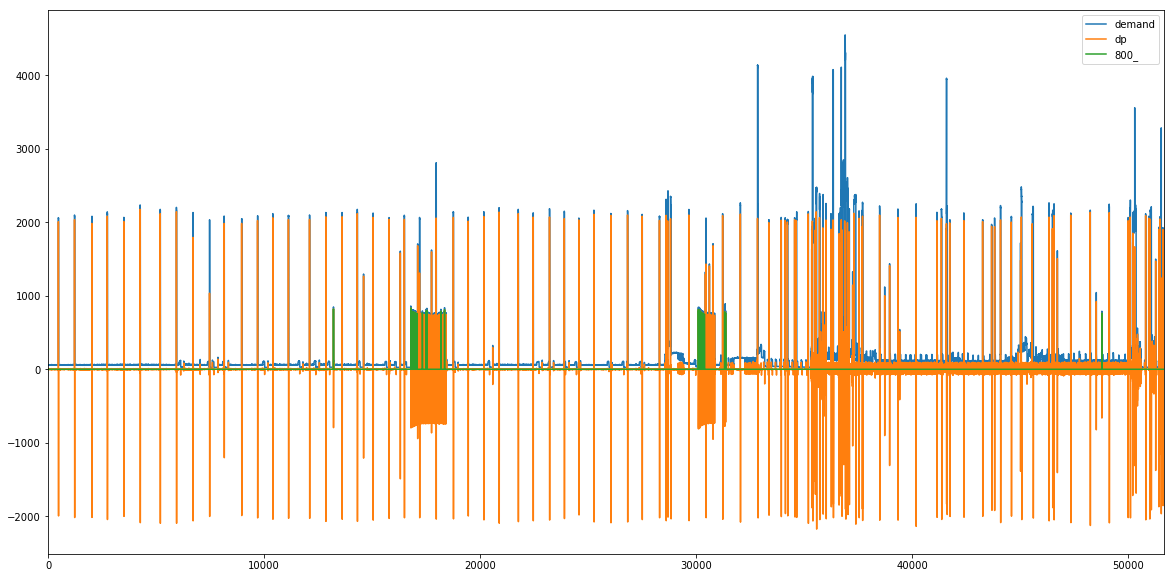

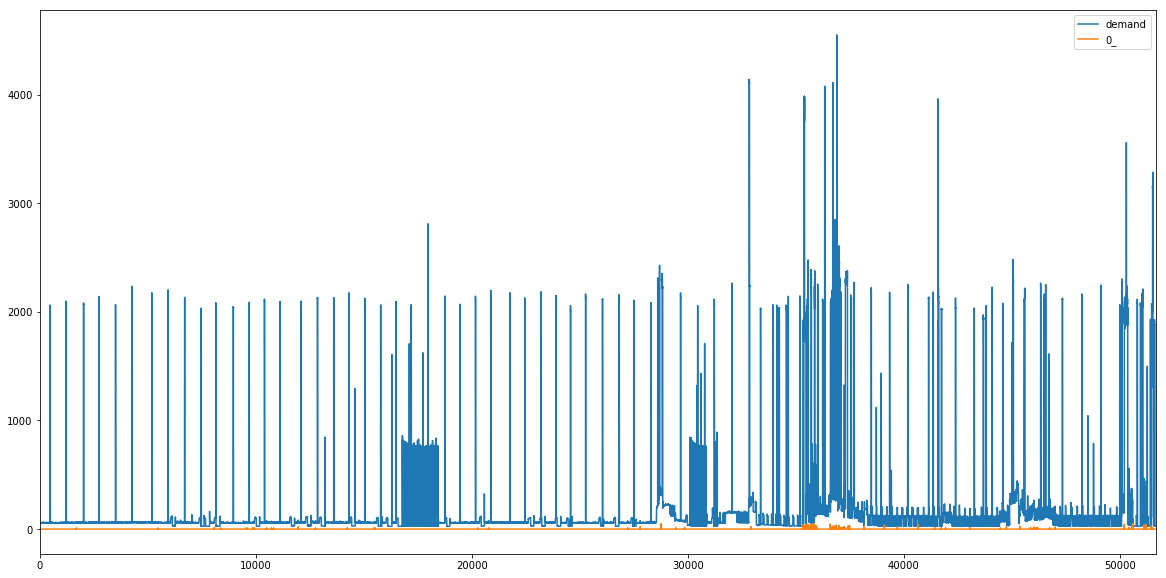

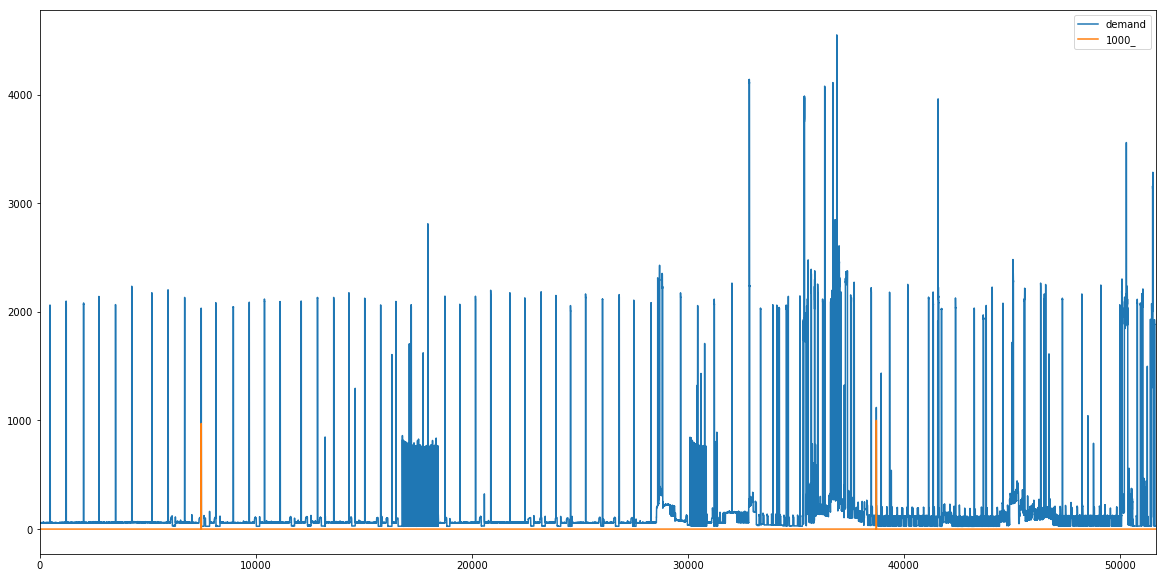

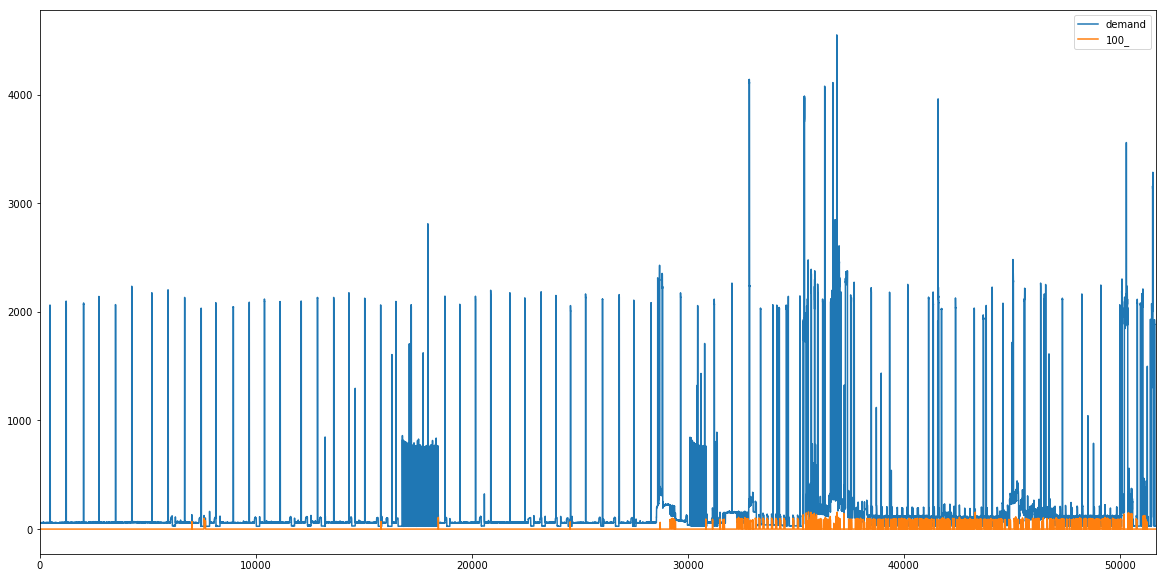

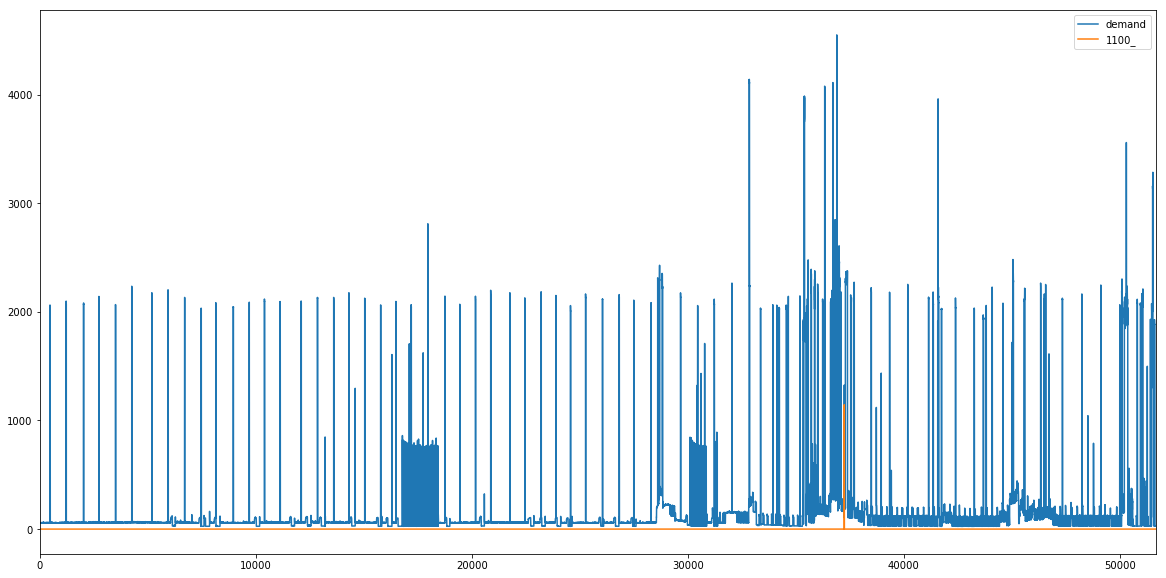

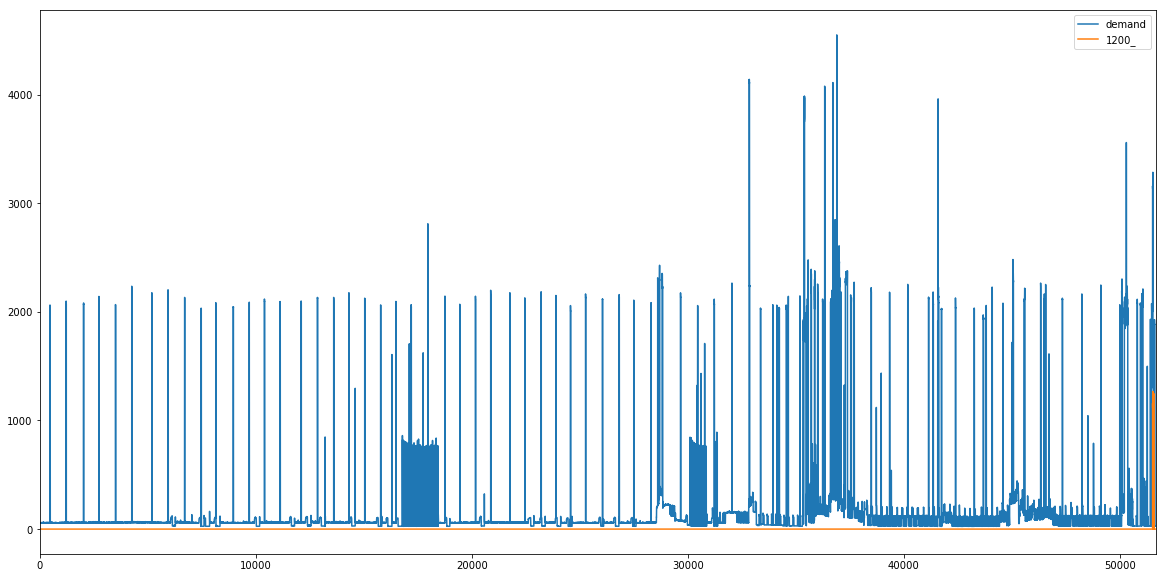

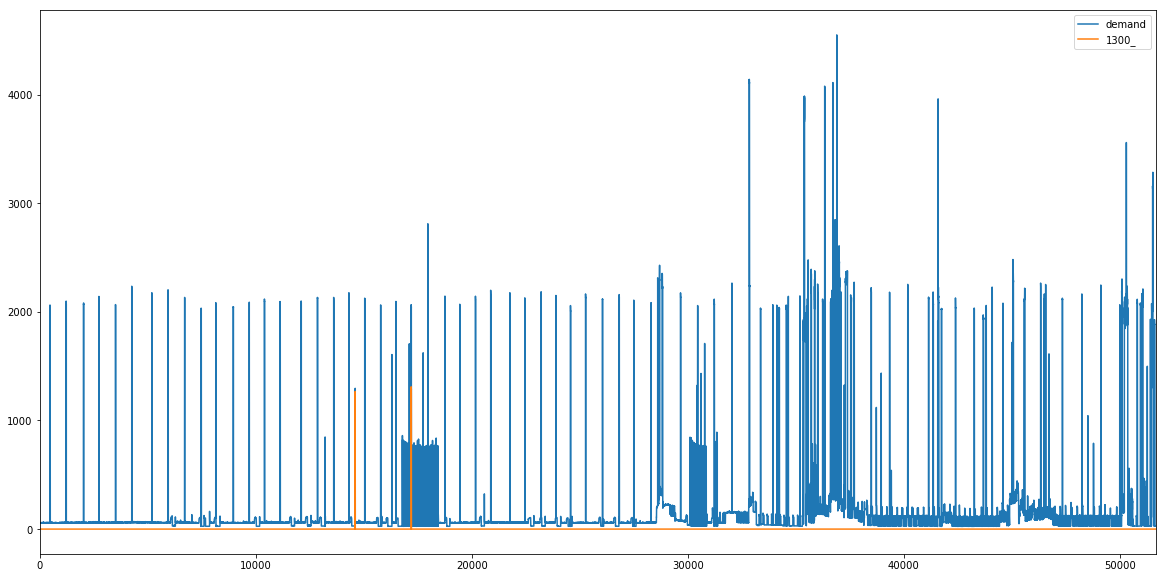

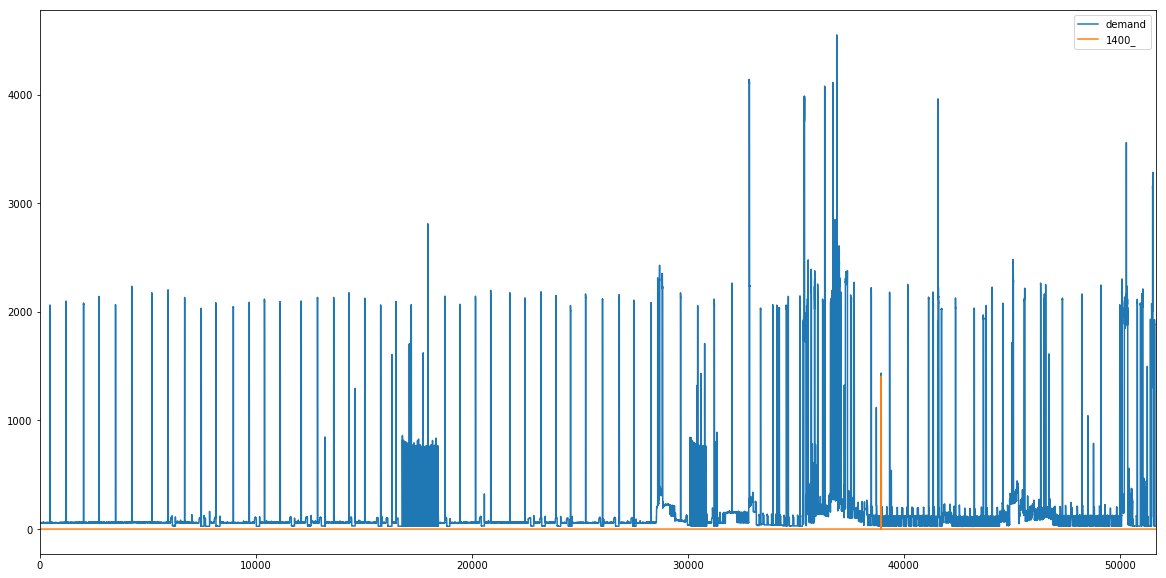

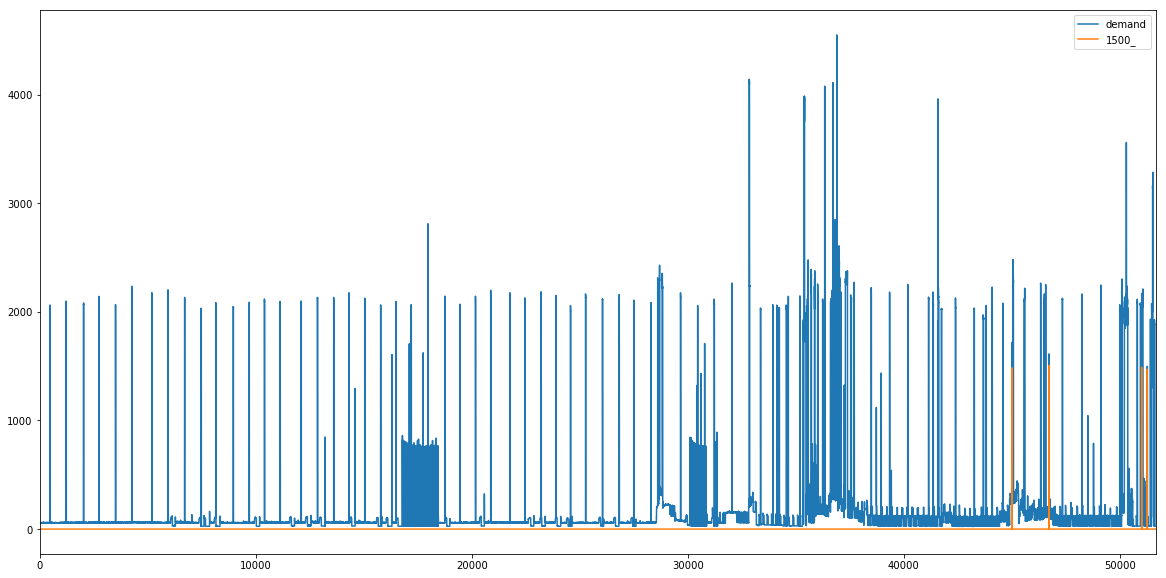

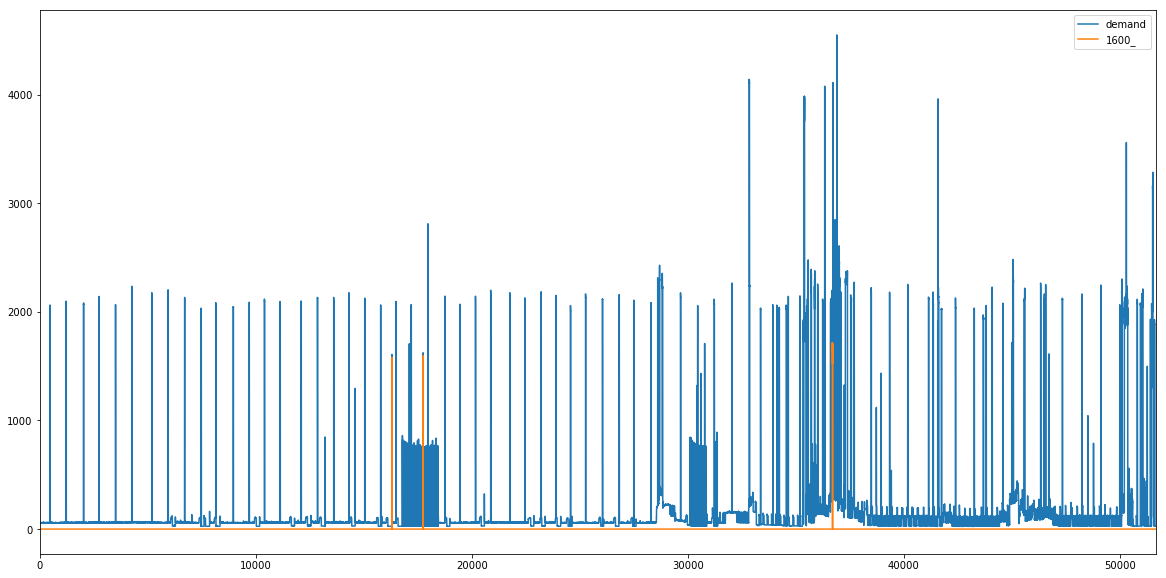

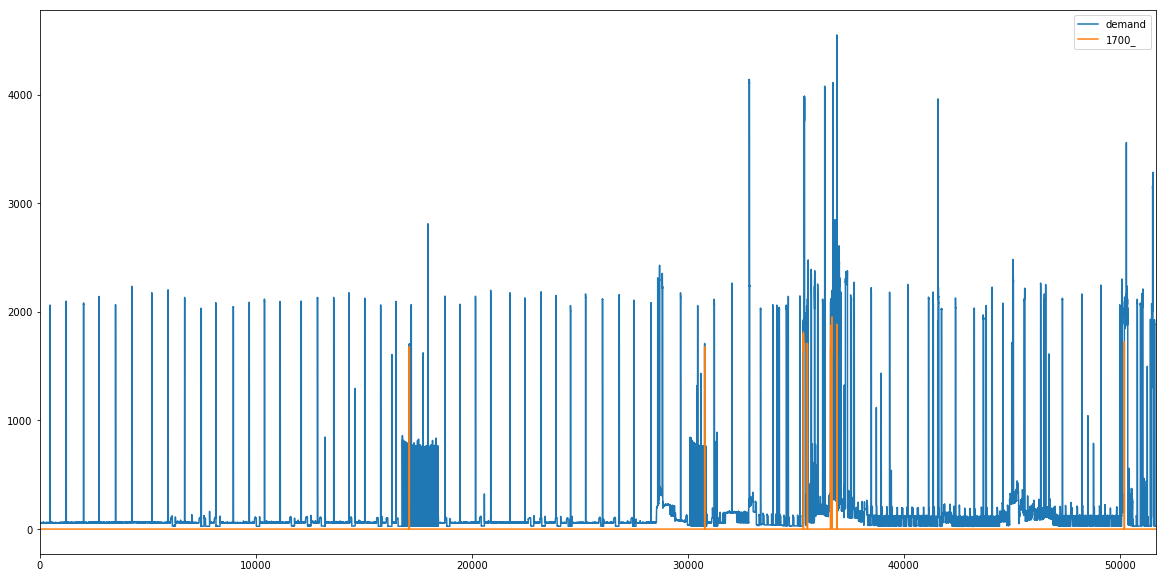

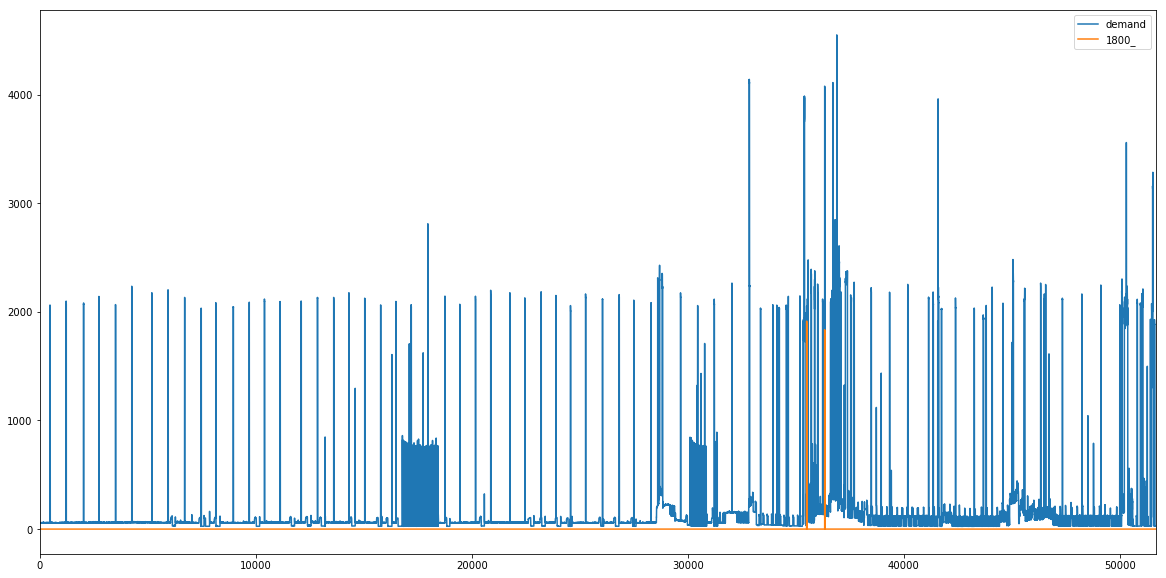

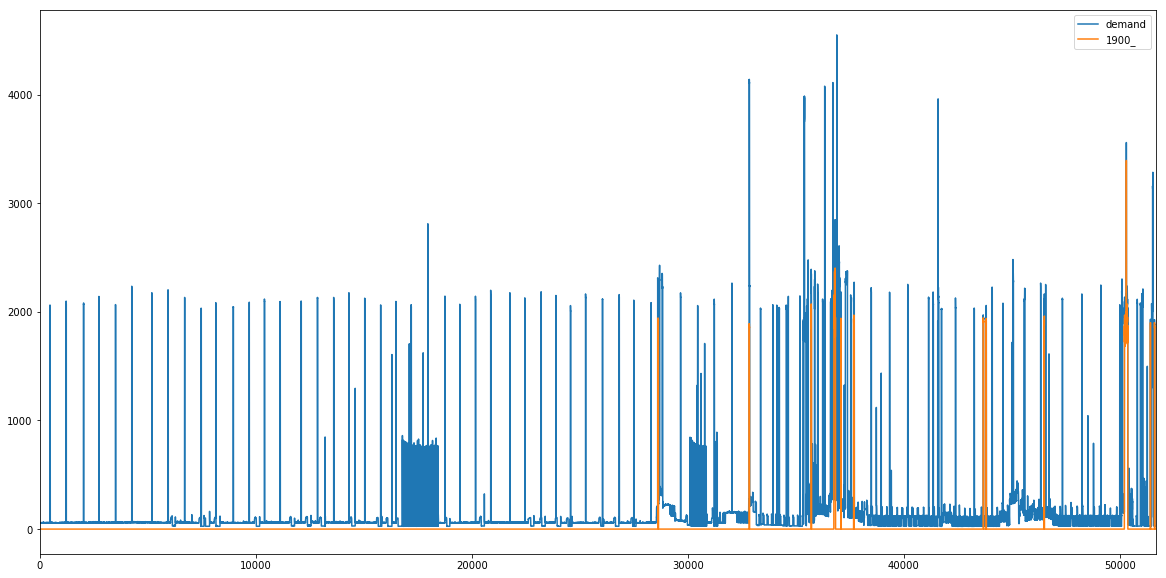

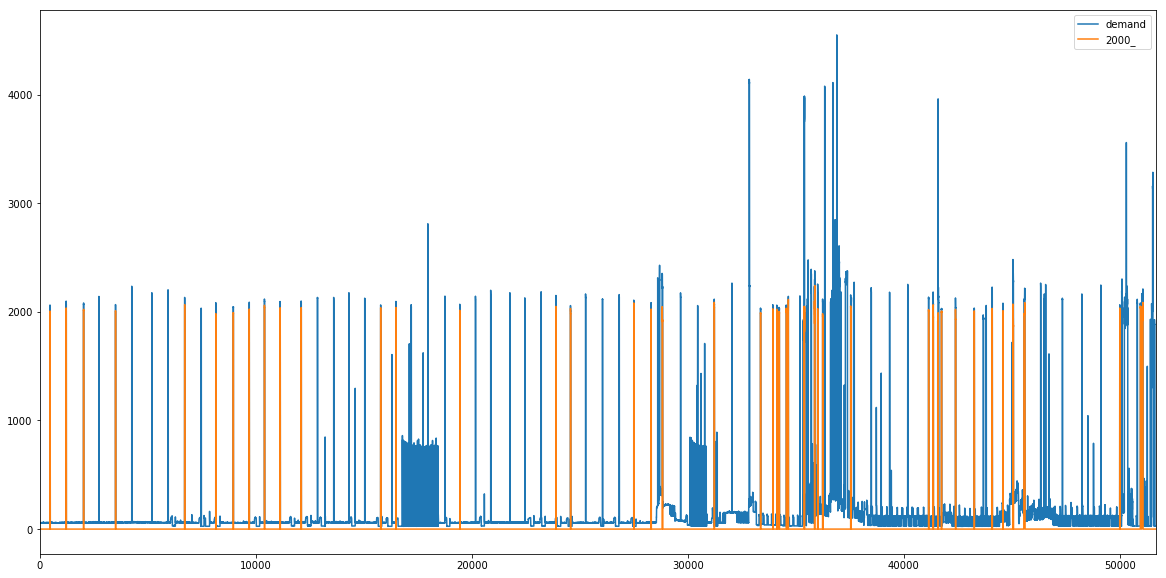

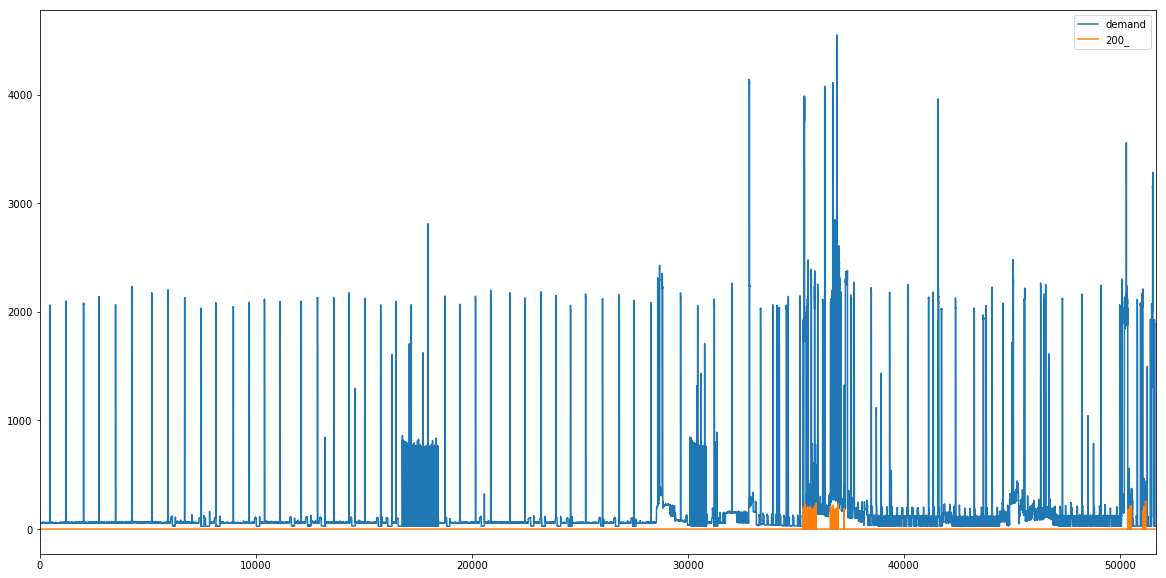

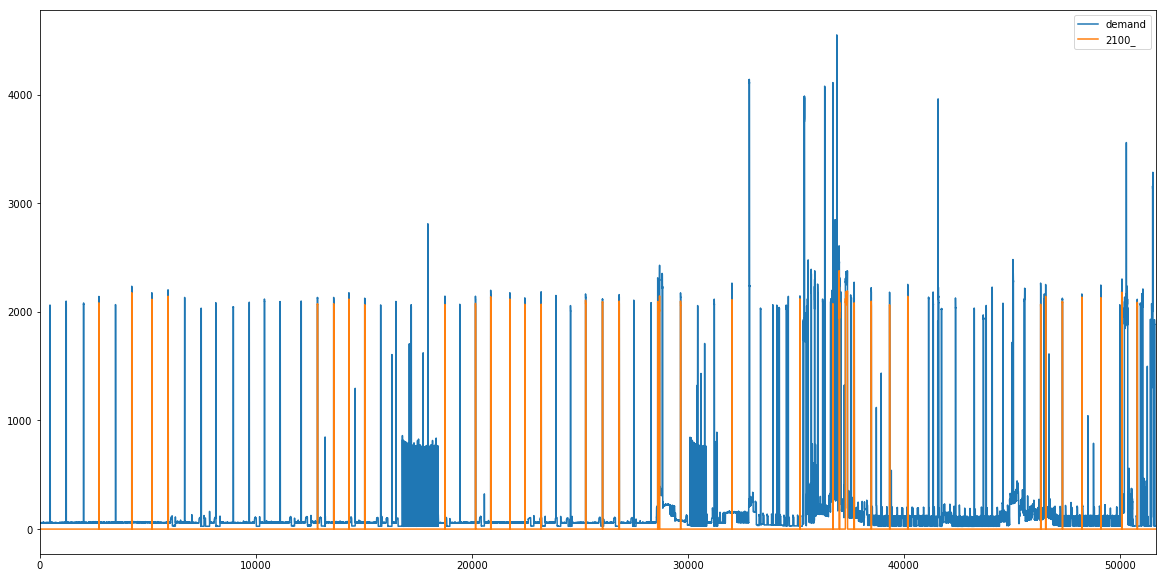

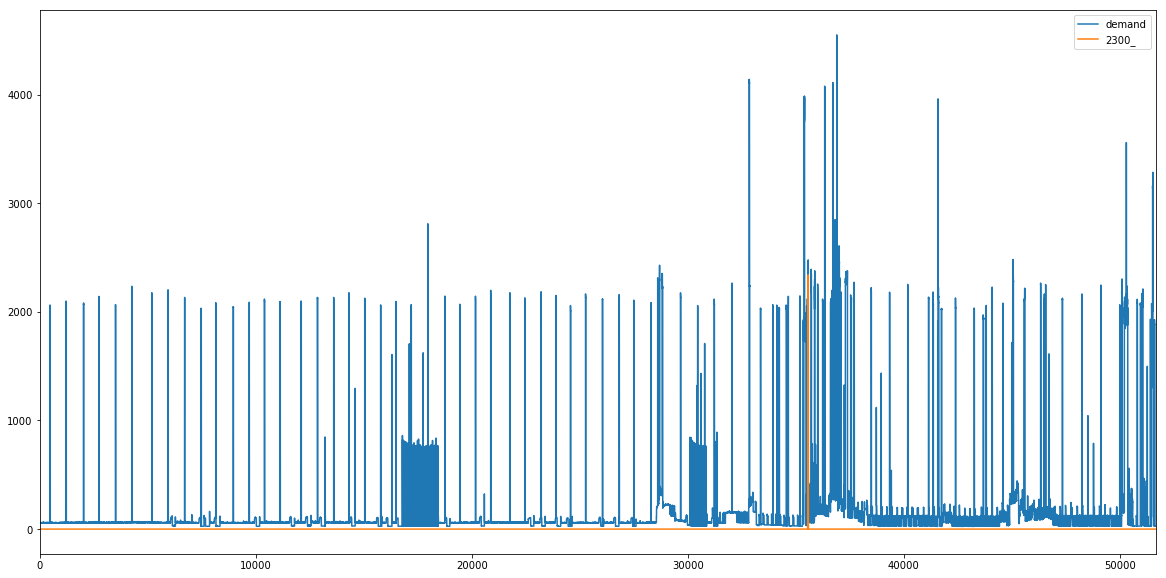

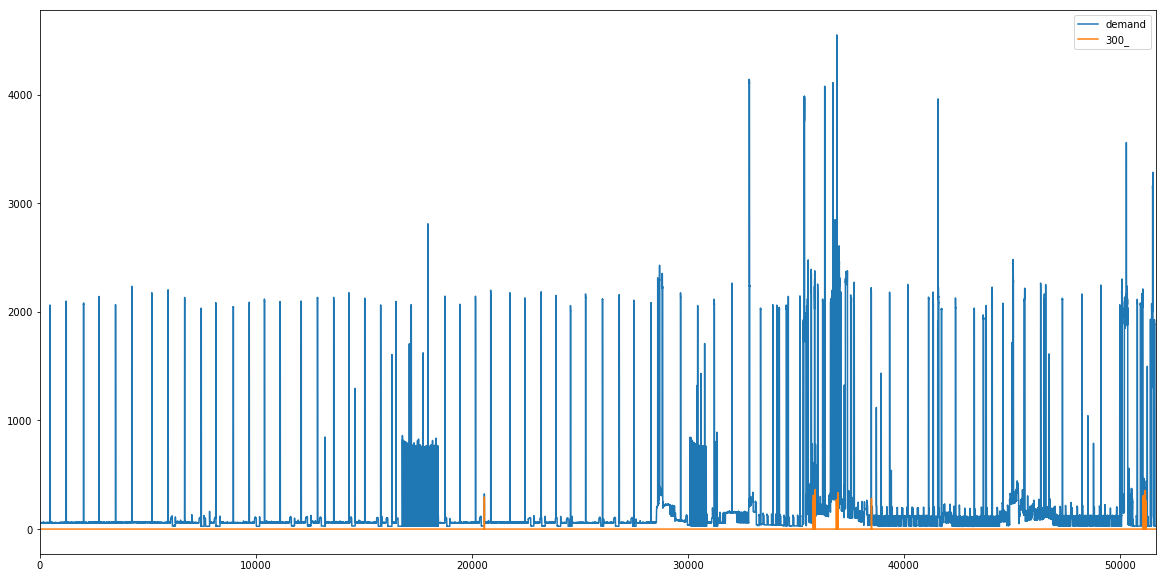

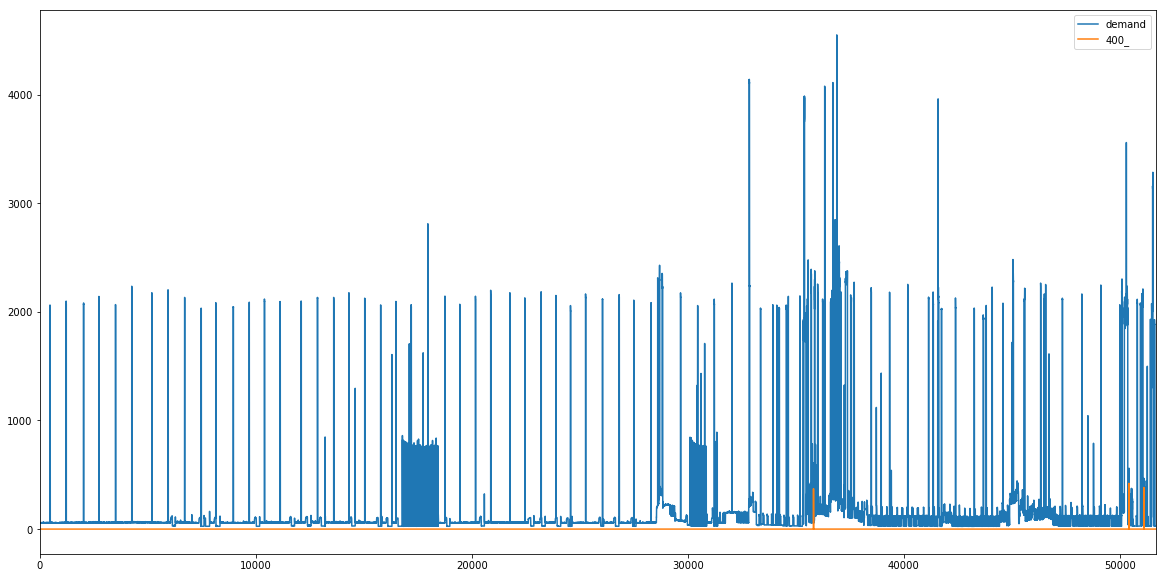

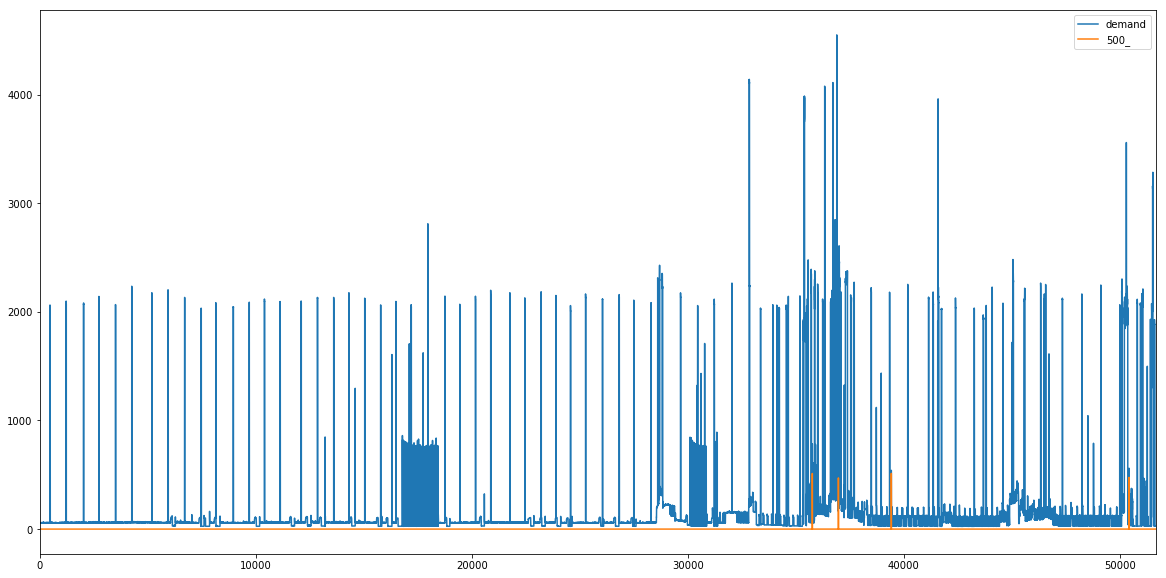

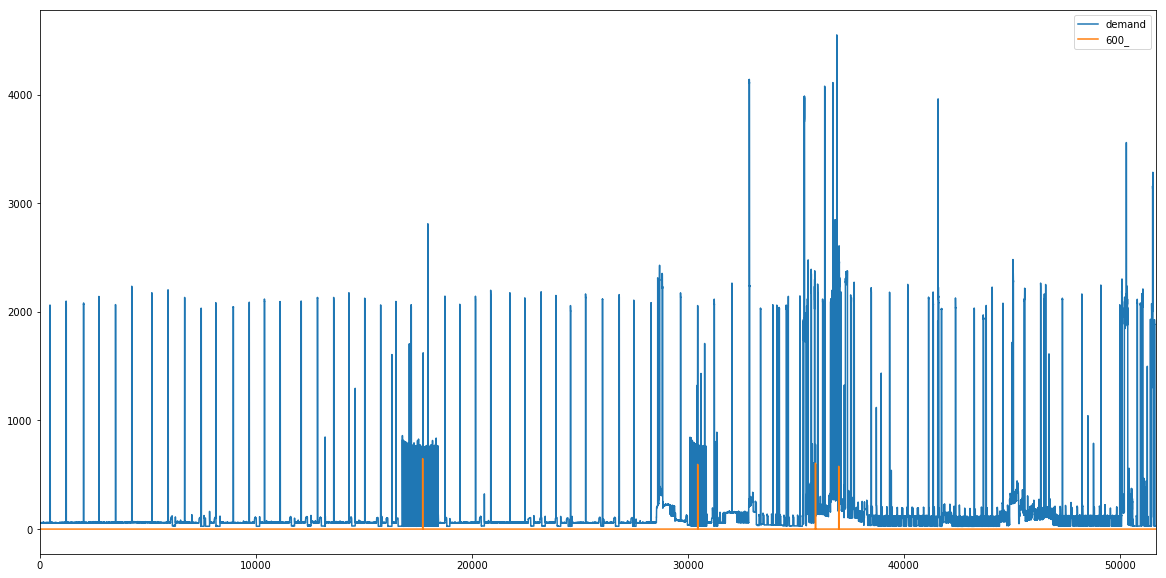

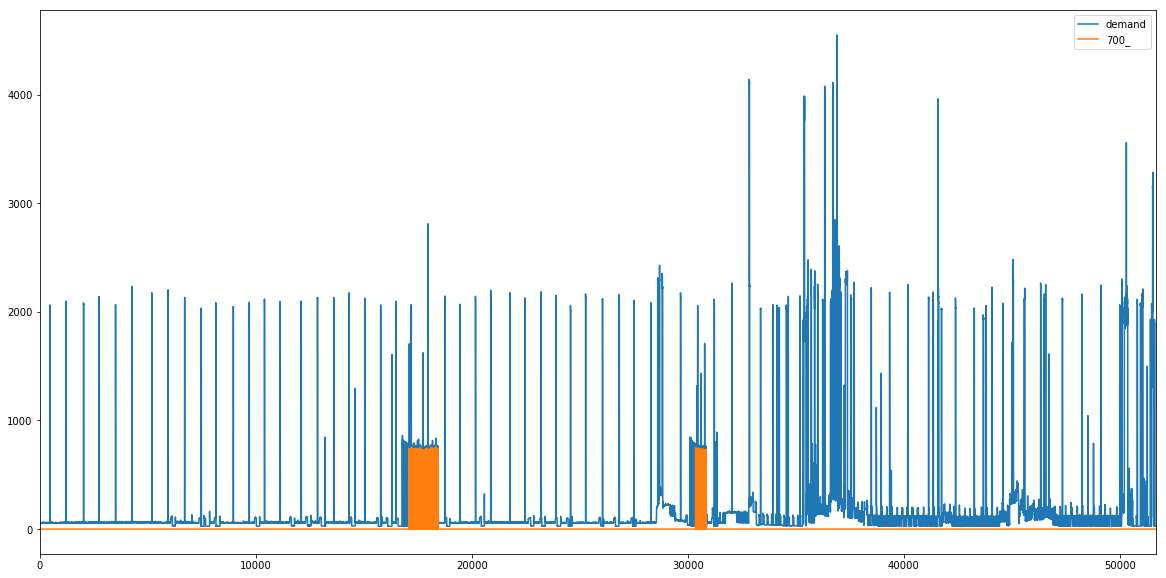

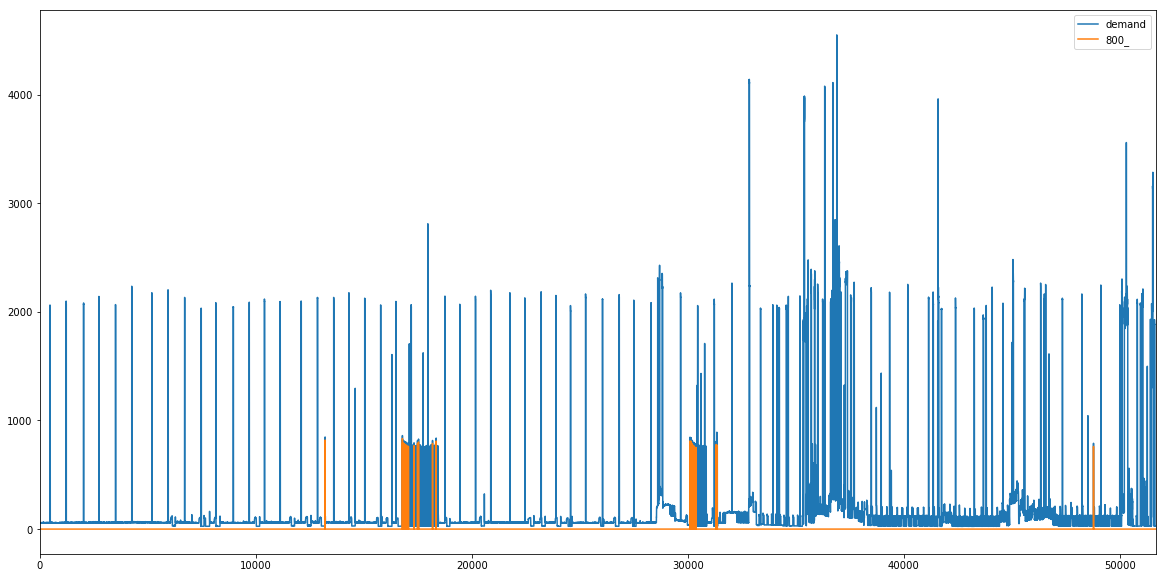

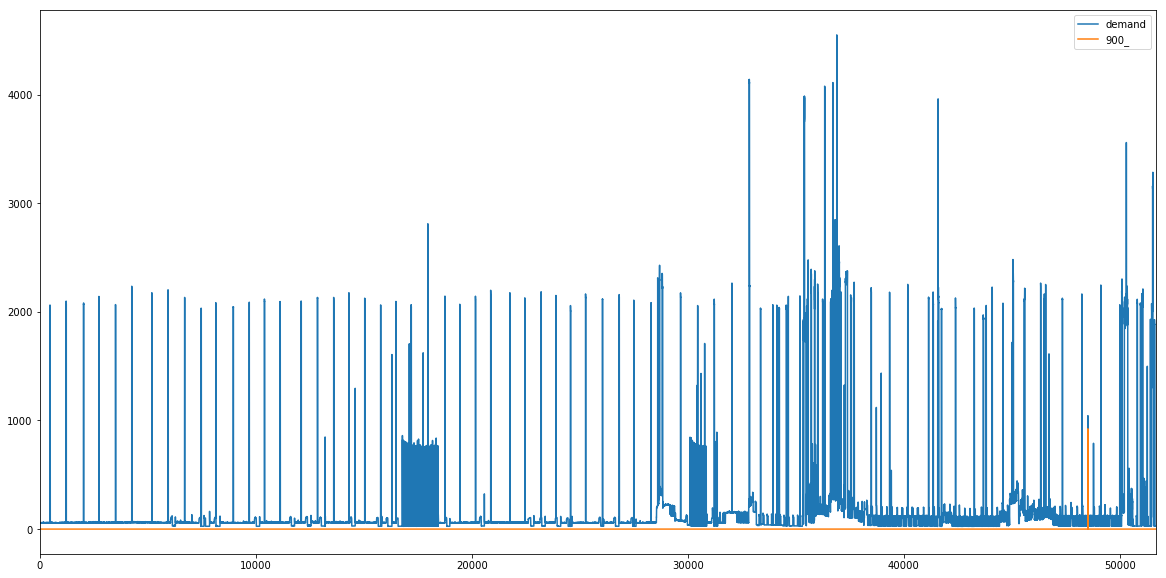

In [7]:
#print(df.loc[7770:7847,['demand','baseload','unknown','800_']])
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

df.loc[:,['demand','dp','800_']].plot(figsize=(20,10))
for i in sorted(loads):
    print(i,'has',len(loads[i]),'occurance(s)')
    df.loc[:,['demand',i]].plot(figsize=(20,10))


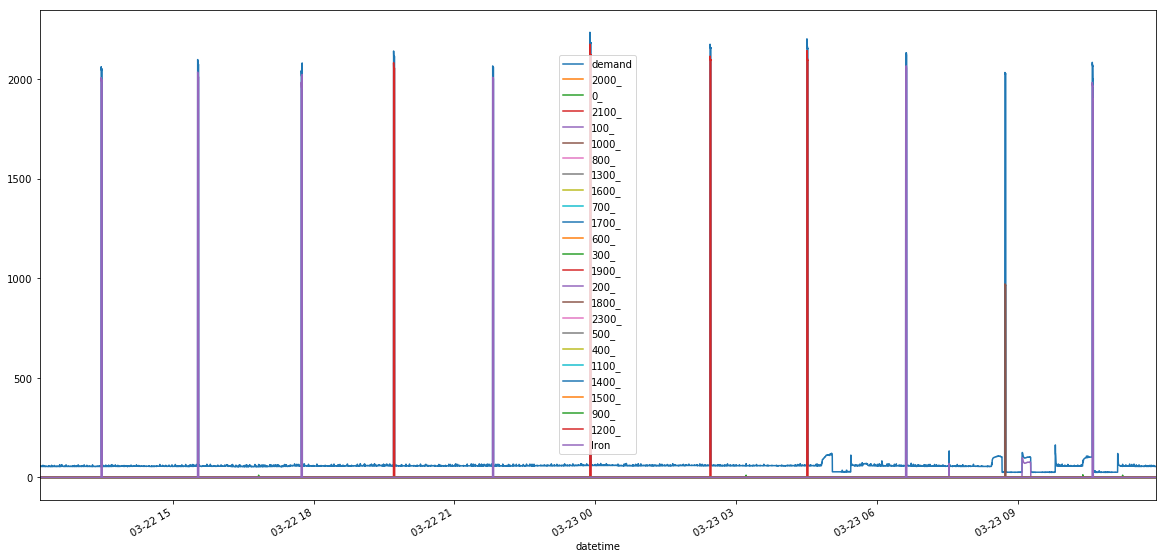

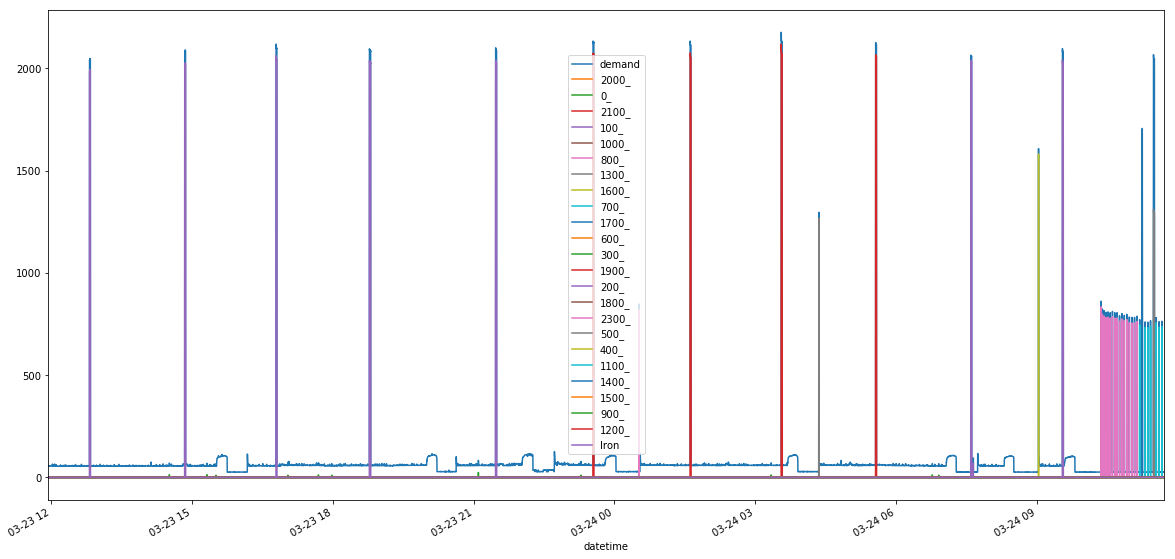

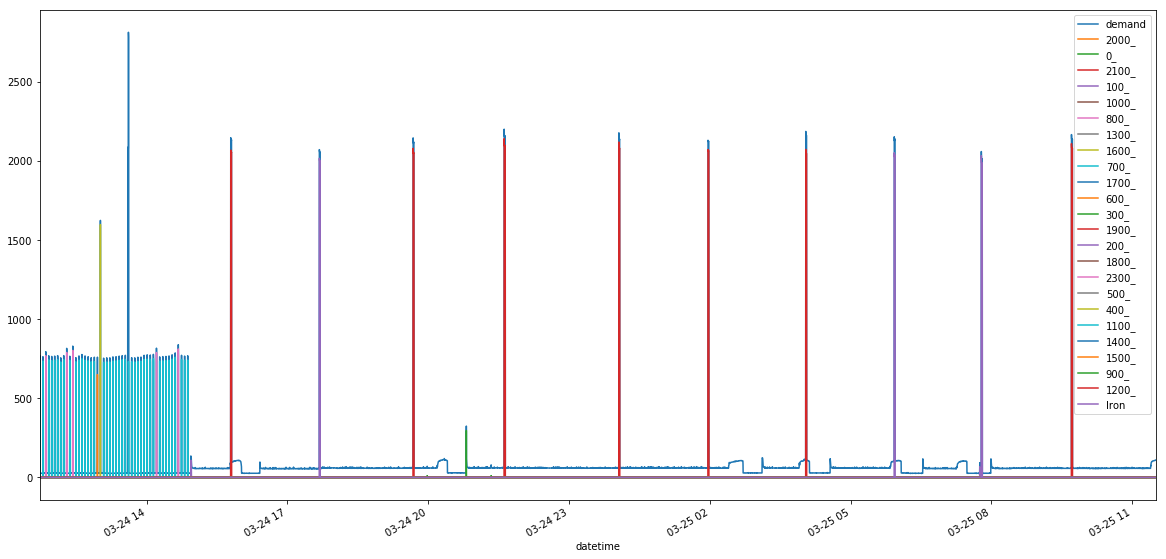

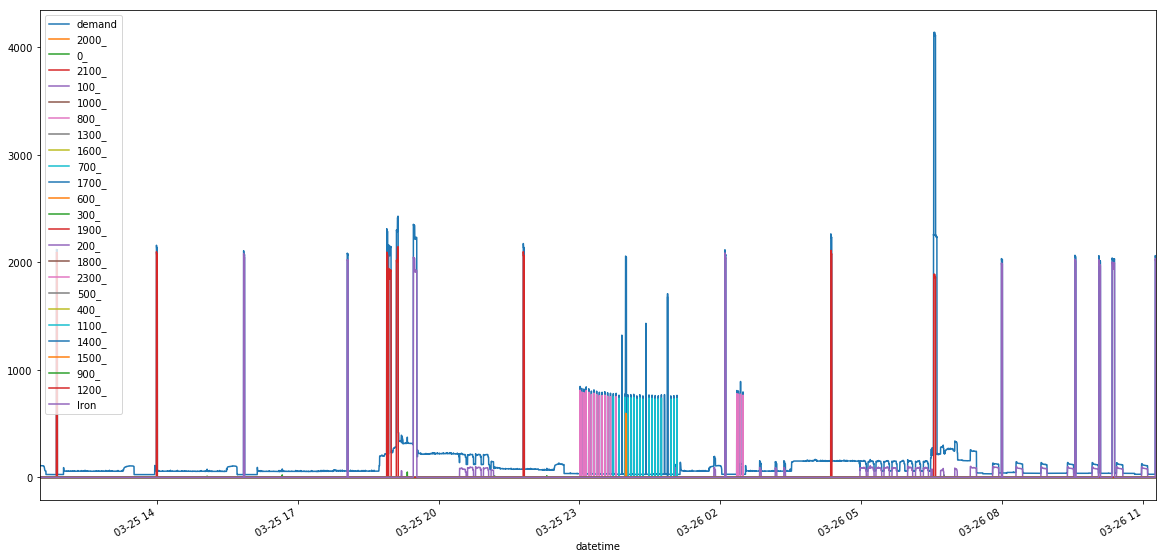

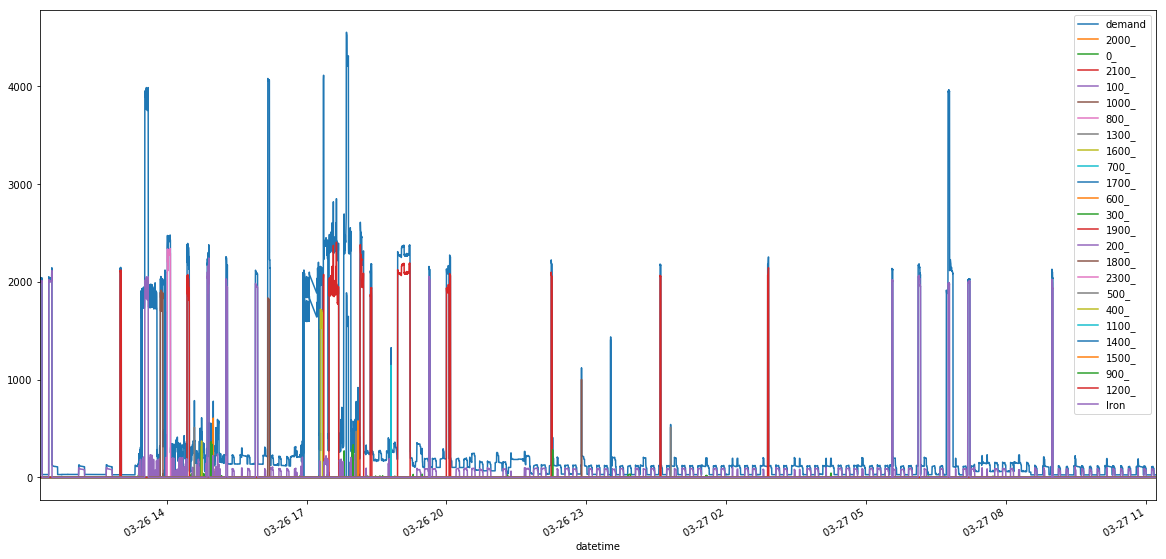

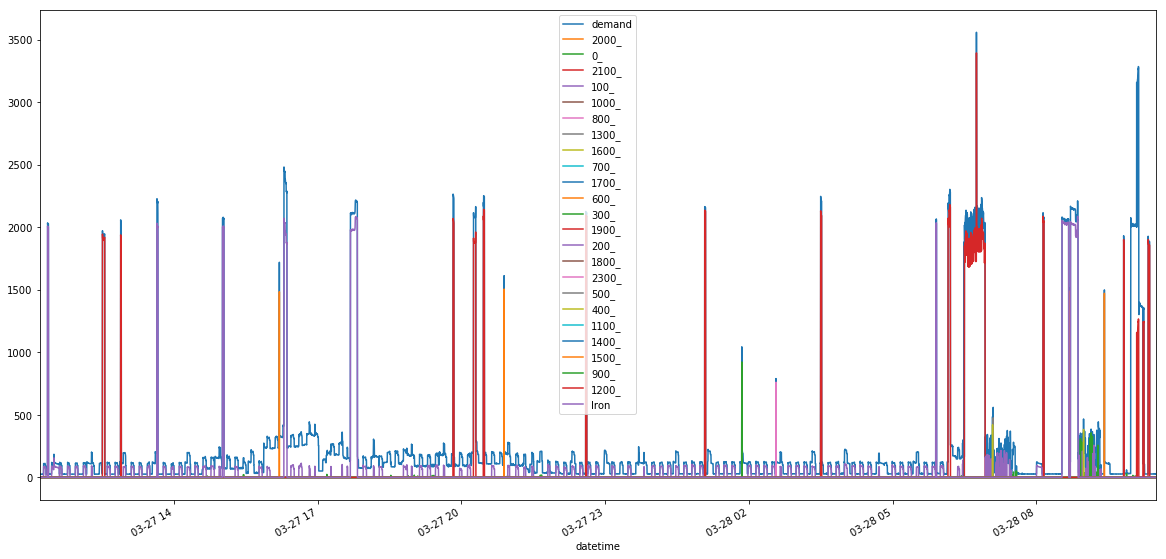

In [14]:
#print(df)
l = list(loads)
l.insert(0, 'datetime')
l.insert(1, 'demand')


step = 360*24 
for i in range(1,len(df),step):
    df.loc[i:i+step,l].plot(x=df.loc[i:i+step,'datetime'],figsize=(20,10))
                            #,kind='area')#,stacked=true)    


In [15]:
print(df.loc[i:i+step,l])

                 datetime  demand  2000_  0_  2100_  100_  1000_  800_  1300_  \
43201 2018-03-27 11:12:12    26.0    NaN   0      0     0      0     0      0   
43202 2018-03-27 11:12:22    25.0    NaN   0      0     0      0     0      0   
43203 2018-03-27 11:12:31    26.0    NaN   0      0     0      0     0      0   
43204 2018-03-27 11:12:41    25.0    NaN   0      0     0      0     0      0   
43205 2018-03-27 11:12:51    25.0    NaN   0      0     0      0     0      0   
43206 2018-03-27 11:13:01    26.0    NaN   0      0     0      0     0      0   
43207 2018-03-27 11:13:11    25.0    NaN   0      0     0      0     0      0   
43208 2018-03-27 11:13:21    25.0    NaN   0      0     0      0     0      0   
43209 2018-03-27 11:13:31    26.0    NaN   0      0     0      0     0      0   
43210 2018-03-27 11:13:41    26.0    NaN   0      0     0      0     0      0   
43211 2018-03-27 11:13:51    25.0    NaN   0      0     0      0     0      0   
43212 2018-03-27 11:14:01   

In [10]:
# print(list(loads['100_'][0]))
for i in sorted(loads):
    print(i,'has',len(loads[i]),'occurance(s)')
    for load in loads[i]:
        if i == '100_':
            print(round(sum(loads[i][load]['profile'])/360,1),'Wh in ',loads[i][load]['time'])
            


0_ has 99 occurance(s)
1000_ has 2 occurance(s)
100_ has 278 occurance(s)
0.2 Wh in  0 days 00:00:10
14.3 Wh in  0 days 00:11:04
0.2 Wh in  0 days 00:00:10
1.5 Wh in  0 days 00:00:49
0.2 Wh in  0 days 00:00:10
0.8 Wh in  0 days 00:00:49
10.7 Wh in  0 days 00:08:26
11.2 Wh in  0 days 00:07:35
10.5 Wh in  0 days 00:07:06
9.2 Wh in  0 days 00:06:37
3.6 Wh in  0 days 00:03:08
2.6 Wh in  0 days 00:01:59
2.7 Wh in  0 days 00:01:59
2.5 Wh in  0 days 00:01:59
2.6 Wh in  0 days 00:01:59
2.5 Wh in  0 days 00:01:59
11.6 Wh in  0 days 00:08:05
11.4 Wh in  0 days 00:07:46
10.3 Wh in  0 days 00:07:16
10.1 Wh in  0 days 00:06:57
9.0 Wh in  0 days 00:06:26
9.5 Wh in  0 days 00:06:26
8.9 Wh in  0 days 00:06:27
9.0 Wh in  0 days 00:06:26
0.3 Wh in  0 days 00:00:10
1.0 Wh in  0 days 00:00:49
4.5 Wh in  0 days 00:04:08
3.9 Wh in  0 days 00:03:09
11.8 Wh in  0 days 00:07:56
12.2 Wh in  0 days 00:07:46
12.1 Wh in  0 days 00:08:25
11.2 Wh in  0 days 00:07:46
11.4 Wh in  0 days 00:07:56
11.3 Wh in  0 days 00:

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Applications/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot com

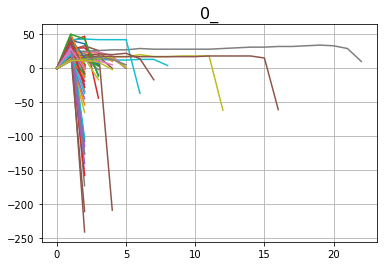

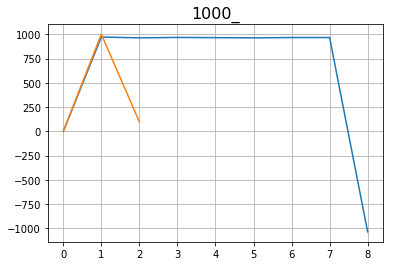

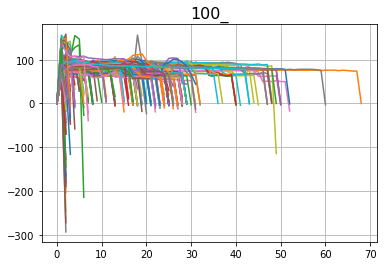

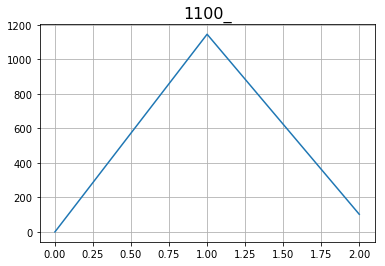

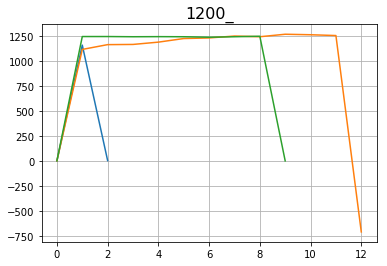

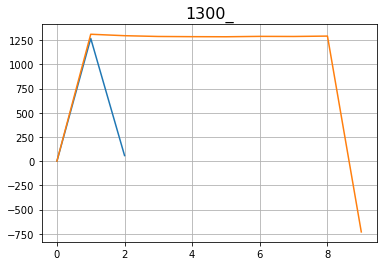

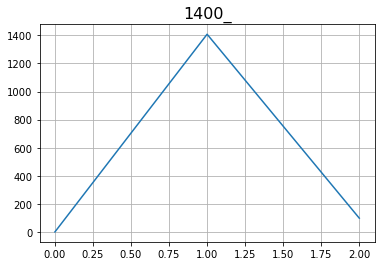

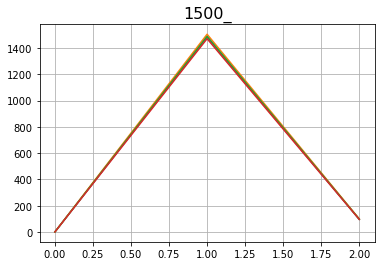

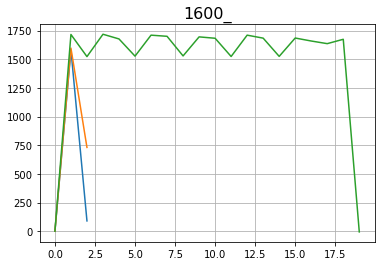

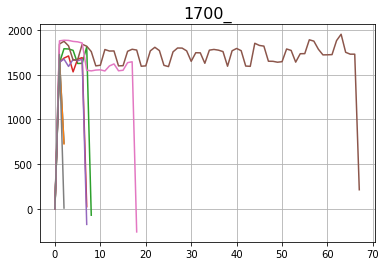

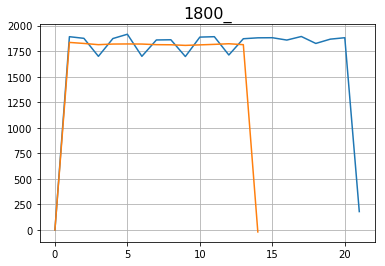

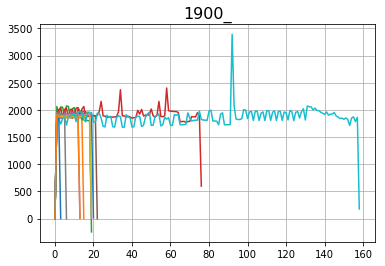

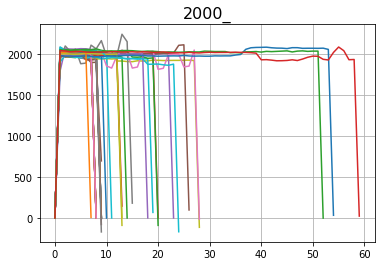

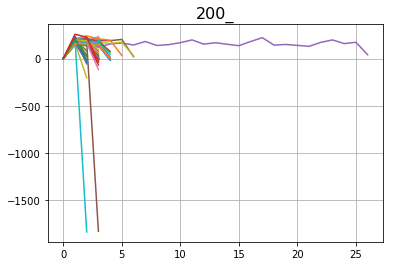

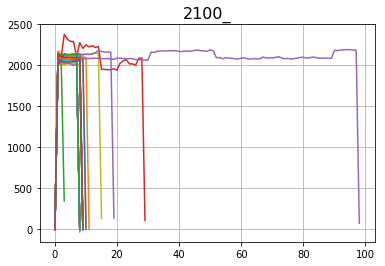

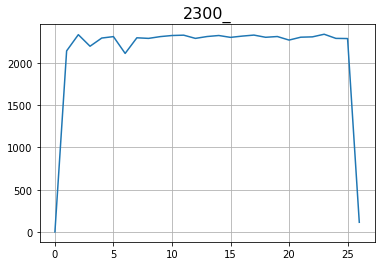

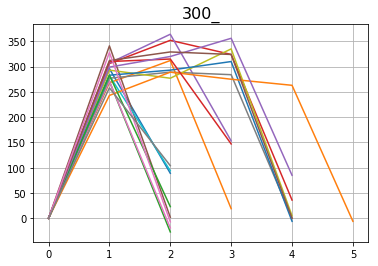

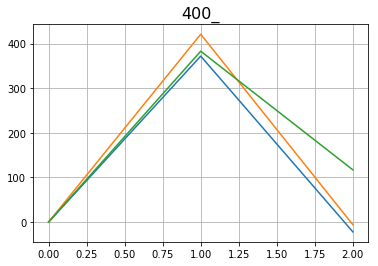

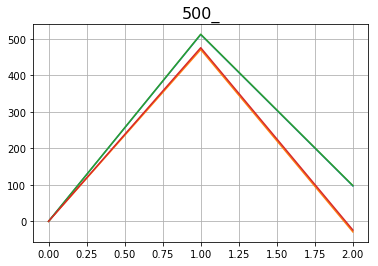

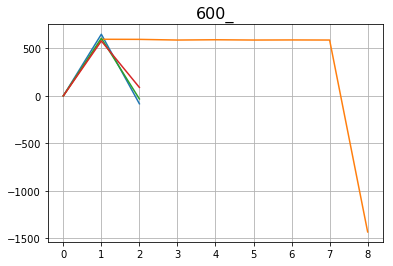

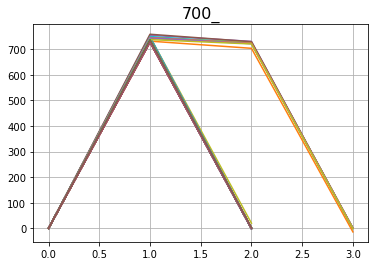

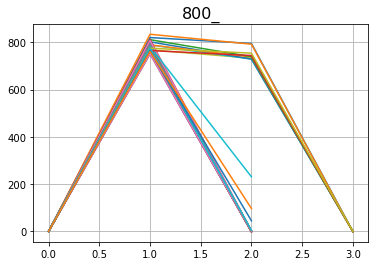

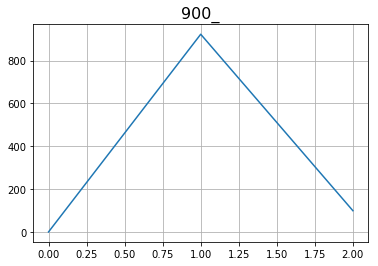

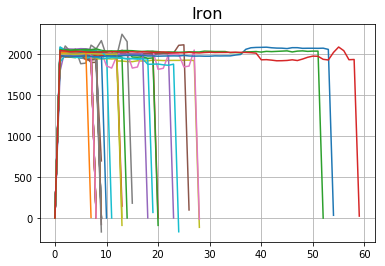

In [43]:
# print(loads)
for i in sorted(loads):
    plt.hold(True)
    for load in loads[i]:
        plt.plot(loads[i][load]['profile'][0:])
    plt.hold(False)
    plt.grid()
    plt.title(i,size=16)
    plt.show()
    


In [11]:

# df[['datetime',list(loads)]].iplot()
temp = list(loads)
temp[0] = 'datetime'
temp[1] = 'baseload'
temp[2] = 'unknown'

temp[3:] =list(loads)
dp = df[temp]
dp = dp.set_index('datetime')
# dp.resample('10T').mean().iplot(kind='area',fill='tozeroy',mode='none')



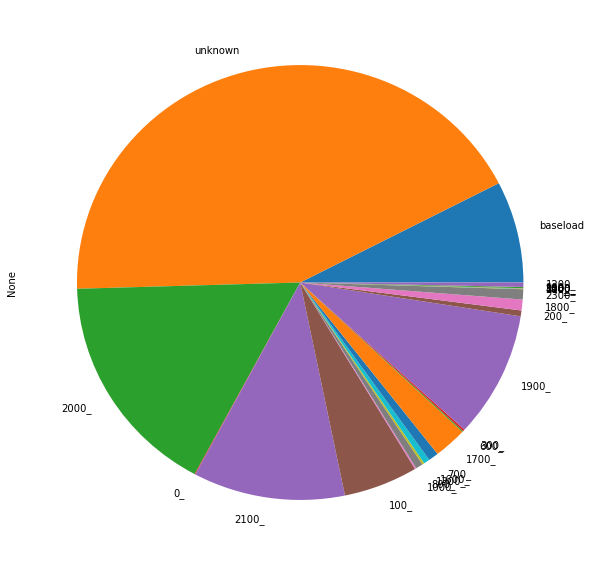

In [12]:
pie = dp.sum()
# values = pie.values/pie.sum()*100
# print(pie)
# print(pie/pie.sum())
round(pie/pie.sum()*100,1)
pie.plot(kind='pie',figsize=(10,10))

# write pie data to db

# Try to rename colums for 'kwown loads' 

In [13]:
#relable output for known_loads
known_loads = {'100_':'Fridge','2000_':'Boiler'}
for name in loads.keys():
    try:
        df=df.rename(columns = {name:known_loads[name]})
        loads[known_loads[name]] = loads[name]
    except:
        print(name,'not found known_loads')
    
for name in known_loads:
    try:
        del loads[name]
    except:
        print(name,'not found in legend')

legend = loads.keys()
print(list(legend))

RuntimeError: dictionary changed size during iteration

In [ ]:
#function left_round round number left of the decimal point. (NEEDS A FIX)
def left_round(number,precision=2):
    rem = number

    d = len(str(number))
    while(round(rem,d) == round(number,d)):
        rem = round(number,d-precision)
        d = d -1
        
    i = 0
    while(rem > 10**precision):
        rem = round(rem / 10,0)
        i = i +1
#         print(rem*(10**i))
        if i > 100:
            break
    return rem*(10**i)

left_round(00.00034564,3)

left_round(122431234.00034564,3)

# left_round(123456)